# Техническое задание Маркетинг

# Содержание

- [Описание проекта](#intro)
- [Подготовка данных](#data)
- [Промежуточный вывод](#report_data)
- [Предобработка данных](#prepare)
- [Промежуточный вывод после предобработки данных](#report_prepare)
- [Исследование данных](#research)
- [Промежуточный вывод после исследования данных](#report_research)
- [Работа с признаками](#features)
- [Промежуточный вывод после работы с признаками](#report_features)
- [Обучение модели](#learn)
- [Предварительный вывод](#report_learn)
- [Предсказание](#predict)
- [Общий вывод](#total_review)

<a id='intro'></a>
# Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время. <br/>
**Цель проекта**: "Предсказать вероятность покупки в течение 90 дней"

Заказчиком предоставлены следующие данные:
<br/>

Датасет *apparel-purchases* - *история покупок* с признаками:
- `client_id` - идентификатор пользователя
- `quantity` - количество товаров в заказе
- `price ` -  цена товара
- `category_ids ` - вложенные категории, к которым отнсится товар
- `date ` - дата покупки
- `message_id ` - идентификатор сообщения из рассылки

Датасет *apparel-messages* - *история рекламных рассылок* с признаками:
- `bulk_campaign_id` - идентификатор рекламной кампании
- `client_id` - идентификатор пользователя
- `message_id` - идентификатор сообщений
- `event` - тип действия
- `channel` - канал рассылки
- `date` - дата рассылки
- `created_at` - точное время создания сообщения


Датасет *apparel-target_binary* - *совершит ли клиент покупку в течение следующих 90 дней* с признаками:
- `client_id` - идентификатор пользователя
- `target` - **целевой признак**



<a id='data'></a>
# Подготовка данных

In [1]:
import ast
import pandas as pd
import importlib.metadata
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import shap
import sklearn
import xgboost as xgb

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (RandomizedSearchCV, 
                                     train_test_split)
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             f1_score, 
                             recall_score, 
                             precision_score, 
                             confusion_matrix, 
                             classification_report,
                             roc_curve, 
                             roc_auc_score, 
                             precision_recall_curve)
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
libraries = ['pandas', 'matplotlib', 'numpy', 
             'seaborn', 'shap', 'xgboost', 'phik', 
             'scikit-learn', 'statsmodels']

for lib in libraries:
    try:
        version = importlib.metadata.version(lib)
        print(f"{lib}: {version}")
    except importlib.metadata.PackageNotFoundError:
        print(f"{lib} не установлен.")

pandas: 2.2.1
matplotlib: 3.8.4
numpy: 1.26.4
seaborn: 0.13.2
shap: 0.45.1
xgboost: 2.1.0
phik: 0.12.4
scikit-learn: 1.5.0
statsmodels: 0.14.2


In [3]:
pd.options.display.float_format = '{:.18f}'.format

In [4]:
RANDOM_STATE = 42

In [5]:
m1 = 'apparel-messages.csv'
m2 = '/datasets/apparel-messages.csv'
p1 = 'apparel-purchases.csv'
p2 = '/datasets/apparel-purchases.csv'
t1 = 'apparel-target_binary.csv'
t2 = '/datasets/apparel-target_binary.csv'

In [6]:
def load_df(pth1, pth2, *args):
    if os.path.exists(pth1):
        df = pd.read_csv(pth1, parse_dates=list(args))
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, parse_dates=list(args))
    else:
        print('Something is wrong')
    return df

In [7]:
dfm = load_df(m1, m2, 'date', 'created_at')

In [8]:
dfp = load_df(p1, p2, 'date')

In [9]:
dft = load_df(t1, t2)

dfm = pd.read_csv('apparel-messages.csv', parse_dates=['date', 'created_at'])

dfp = pd.read_csv('apparel-purchases.csv', parse_dates=['date'])

dft = pd.read_csv('apparel-target_binary.csv')

In [10]:
def show_info(data):
    """
    Функция которая выводит общую информацию по датафрейму
    """
    print('------------- Исходный датафрейм -------------')
    display(data.head())
    print('')
    print('------------- Общая информация о датафрейме -------------')
    print('')
    display(data.info())
    print('------------- Количество пустых значений в датафрейме -------------')
    print('')
    display(data.isna().sum())
    print('------------- Количество явных дубликатов в датафрейме -------------')
    display(data.duplicated().sum())
    print('')
    print('------------- Описательная статистика -------------')
    display(data.describe(include='all'))
    print('')
    print('------------- Количество уникальных значений -------------')
    display(data.nunique())

In [11]:
show_info(dfm)

------------- Исходный датафрейм -------------


bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   
3              4439  1515915625553578558   
4              4439  1515915625471518311   

                               message_id  event channel       date  \
0  1515915625626736623-4439-6283415ac07ea   open   email 2022-05-19   
1  1515915625490086521-4439-62834150016dd   open   email 2022-05-19   
2  1515915625553578558-4439-6283415b36b4f   open   email 2022-05-19   
3  1515915625553578558-4439-6283415b36b4f  click   email 2022-05-19   
4  1515915625471518311-4439-628341570c133   open   email 2022-05-19   

           created_at  
0 2022-05-19 00:14:20  
1 2022-05-19 00:39:34  
2 2022-05-19 00:51:49  
3 2022-05-19 00:52:20  
4 2022-05-19 00:56:52


------------- Общая информация о датафрейме -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

------------- Количество пустых значений в датафрейме -------------



bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


48610


------------- Описательная статистика -------------


bulk_campaign_id                              client_id  \
count  12739798.000000000000000000            12739798.000000000000000000   
unique                         NaN                                    NaN   
top                            NaN                                    NaN   
freq                           NaN                                    NaN   
mean      11604.587587103029363789 1515915625574831616.000000000000000000   
min         548.000000000000000000 1515915625468060928.000000000000000000   
25%        8746.000000000000000000 1515915625489149440.000000000000000000   
50%       13516.000000000000000000 1515915625503432192.000000000000000000   
75%       14158.000000000000000000 1515915625591286272.000000000000000000   
max       14657.000000000000000000 1515915626010288640.000000000000000000   
std        3259.211131189759271365           132970411.558955192565917969   

                                    message_id     event      channel  \
count                                 12739798  12739798     12739798   
unique                                 9061667        11            2   
top     1515915625489095763-6251-6311b13a4cf78      send  mobile_push   
freq                                      1454   9058196      7512156   
mean                                       NaN       NaN          NaN   
min                                        NaN       NaN          NaN   
25%                                        NaN       NaN          NaN   
50%                                        NaN       NaN          NaN   
75%                                        NaN       NaN          NaN   
max                                        NaN       NaN          NaN   
std                                        NaN       NaN          NaN   

                                 date                     created_at  
count                        12739798                       12739798  
unique                            NaN                            NaN  
top                               NaN                            NaN  
freq                              NaN                            NaN  
mean    2023-06-05 02:46:08.357990400  2023-06-05 13:58:11.168689408  
min               2022-05-19 00:00:00            2022-05-19 00:14:20  
25%               2022-12-19 00:00:00            2022-12-19 12:46:30  
50%               2023-07-20 00:00:00            2023-07-20 17:21:54  
75%               2023-11-21 00:00:00            2023-11-21 18:13:05  
max               2024-02-15 00:00:00            2024-02-15 23:58:40  
std                               NaN                            NaN


------------- Количество уникальных значений -------------


bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

In [12]:
show_info(dfp)

------------- Исходный датафрейм -------------


client_id  quantity                   price  \
0  1515915625468169594         1 1999.000000000000000000   
1  1515915625468169594         1 2499.000000000000000000   
2  1515915625471138230         1 6499.000000000000000000   
3  1515915625471138230         1 4999.000000000000000000   
4  1515915625471138230         1 4999.000000000000000000   

                category_ids       date  \
0   ['4', '28', '57', '431'] 2022-05-16   
1   ['4', '28', '57', '431'] 2022-05-16   
2   ['4', '28', '57', '431'] 2022-05-16   
3  ['4', '28', '244', '432'] 2022-05-16   
4   ['4', '28', '49', '413'] 2022-05-16   

                               message_id  
0  1515915625468169594-4301-627b661e9736d  
1  1515915625468169594-4301-627b661e9736d  
2  1515915625471138230-4437-6282242f27843  
3  1515915625471138230-4437-6282242f27843  
4  1515915625471138230-4437-6282242f27843


------------- Общая информация о датафрейме -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

------------- Количество пустых значений в датафрейме -------------



client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


73020


------------- Описательная статистика -------------


client_id                  quantity  \
count               202208.000000000000000000 202208.000000000000000000   
unique                                    NaN                       NaN   
top                                       NaN                       NaN   
freq                                      NaN                       NaN   
mean   1515915625596210944.000000000000000000      1.006483423009969957   
min    1515915625468060928.000000000000000000      1.000000000000000000   
25%    1515915625490081280.000000000000000000      1.000000000000000000   
50%    1515915625557177088.000000000000000000      1.000000000000000000   
75%    1515915625624391936.000000000000000000      1.000000000000000000   
max    1515915626010443520.000000000000000000     30.000000000000000000   
std              145945755.930884093046188354      0.184383677449078187   

                           price              category_ids  \
count  202208.000000000000000000                    202208   
unique                       NaN                       933   
top                          NaN  ['4', '28', '57', '431']   
freq                         NaN                      8626   
mean     1193.301516260484277154                       NaN   
min         1.000000000000000000                       NaN   
25%       352.000000000000000000                       NaN   
50%       987.000000000000000000                       NaN   
75%      1699.000000000000000000                       NaN   
max     85499.000000000000000000                       NaN   
std      1342.252663595642843575                       NaN   

                                 date                              message_id  
count                          202208                                  202208  
unique                            NaN                                   50204  
top                               NaN  1515915625489095763-6251-6311b13a4cf78  
freq                              NaN                                     365  
mean    2023-03-17 02:49:35.739832064                                     NaN  
min               2022-05-16 00:00:00                                     NaN  
25%               2022-11-12 00:00:00                                     NaN  
50%               2023-04-12 00:00:00                                     NaN  
75%               2023-07-03 00:00:00                                     NaN  
max               2024-02-16 00:00:00                                     NaN  
std                               NaN                                     NaN


------------- Количество уникальных значений -------------


client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

In [13]:
show_info(dft)

------------- Исходный датафрейм -------------


client_id  target
0  1515915625468060902       0
1  1515915625468061003       1
2  1515915625468061099       0
3  1515915625468061100       0
4  1515915625468061170       0


------------- Общая информация о датафрейме -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

------------- Количество пустых значений в датафрейме -------------



client_id    0
target       0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------


0


------------- Описательная статистика -------------


client_id                   target
count               49849.000000000000000000 49849.000000000000000000
mean  1515915625598796032.000000000000000000     0.019278220225079742
std             148794654.890607029199600220     0.137502544465427062
min   1515915625468060928.000000000000000000     0.000000000000000000
25%   1515915625489972736.000000000000000000     0.000000000000000000
50%   1515915625556614912.000000000000000000     0.000000000000000000
75%   1515915625633408768.000000000000000000     0.000000000000000000
max   1515915626010443520.000000000000000000     1.000000000000000000


------------- Количество уникальных значений -------------


client_id    49849
target           2
dtype: int64

<a id='report_data'></a>
# Предварительный вывод

На данном этапе были загружены все три датафрейма и рассмотрена общая информация по ним. </br>
Увидели что датафрейм `apparel-messages` содержит 12739798 строк и 7 признаков. Признаки содержат числовые, даты и строковые типы данных. Кроме того выявлено 48610 явных дубликатов. При этом признак `event` содержит 11 уникальных значений, а признак `channel` - 2. Признак `created_at` дублирует признак `date` кроче добавления времени, поэтому никакой ценности не несет. </br>
Датафрейм `apparel-purchases` содержит 202208 строк и 6 признаков. Признаки содержат числовые, даты и строковые типы данных. Кроме того выявлено 73020 явных дубликатов. </br>
Датафрейм `apparel-target_binary` содержит 49849 строк и 2 признака, один из которых бинарный.</br>
Также определилили что признак `client_id` присутствует в каждом датасете, поэтому он будет использоваться в качестве ключевого.</br>

<a id='prepare'></a>
# Предобработка данных

На данном этапе исправим выявленные недостатки при первичном просмотре данных. Удалим все явные дубликаты, а также признак `created_at`.

In [14]:
dfp.shape

(202208, 6)

In [15]:
dfp.duplicated().sum()

73020

In [16]:
dfp = dfp.drop_duplicates(keep='first')

In [17]:
dfp.shape

(129188, 6)

In [18]:
dfm.shape

(12739798, 7)

In [19]:
dfm.duplicated().sum()

48610

In [20]:
dfm = dfm.drop_duplicates(keep='first')

In [21]:
dfm = dfm.drop(['created_at'], axis=1)

In [22]:
dfm.shape

(12691188, 6)

<a id='report_prepare'></a>
# Предварительный вывод

На данном этапе мы провели предобработку данных для дальнейшего анализа. Удалили все явные дубликаты, а также признак `created_at`.<br/>
После предобработки данных, `apparel-messages` содержит 12691188 строк и 6 признаков, а `apparel-purchases` содержит 129188 и 6 признаков.<br/>

<a id='research'></a>
# Исследовательский анализ

Рассмотрим графическое представление данных.

Создадим 5 новых признаков разбив `category_ids_` на отдельные.

In [23]:
dfp['category_ids_'] = dfp['category_ids'].apply(ast.literal_eval)

In [24]:
dfp[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']] = pd.DataFrame(
    dfp['category_ids_'].apply(lambda x: (x + ['0'] * 5)[:5]).to_list(), 
    index=dfp.index
)

In [25]:
max_date = dfp['date'].max() 
print(f'Дата последней покупки {max_date}')

Дата последней покупки 2024-02-16 00:00:00


In [26]:
date_minus_90 = max_date - pd.Timedelta(days=90)

Добавим признак который показывает была ли покупка в последние 90 дней.

In [27]:
dfp['count_buy_90'] = np.where(dfp['date'] >= date_minus_90, 1, 0)

Добавим признак подсчитывающий выручку.

In [28]:
dfp['revenue'] = dfp['quantity'] * dfp['price']

Добавим признак который берет первый день каждого месяца, найдем минимальное и максимальное значение и создадим датафрейм с диапазоном этих дат.

In [29]:
dfp['month'] = dfp['date'].values.astype('datetime64[M]')

In [30]:
dfp['month'].agg(['min','max'])

min   2022-05-01
max   2024-02-01
Name: month, dtype: datetime64[ns]

In [31]:
month = pd.DataFrame(pd.date_range('2022-05-01','2024-02-16',freq='MS'))

In [32]:
month.columns = ['month']

In [33]:
month.head()

month
0 2022-05-01
1 2022-06-01
2 2022-07-01
3 2022-08-01
4 2022-09-01

Создадим датафрейм сгруппировав по `client_id` 

In [34]:
user = dfp.groupby('client_id')['month'].min().reset_index()

In [35]:
user.head()

client_id      month
0  1515915625468060902 2022-05-01
1  1515915625468061003 2023-01-01
2  1515915625468061099 2022-05-01
3  1515915625468061100 2024-02-01
4  1515915625468061170 2023-03-01

In [36]:
user.columns = ['client_id','reg_month']

In [37]:
user.head()

client_id  reg_month
0  1515915625468060902 2022-05-01
1  1515915625468061003 2023-01-01
2  1515915625468061099 2022-05-01
3  1515915625468061100 2024-02-01
4  1515915625468061170 2023-03-01

Добавим ключ в оба датафрейма и объединим их

In [38]:
month['key'] = 1

In [39]:
user['key'] = 1

In [40]:
r = month.merge(user,on='key')

In [41]:
r.head()

month  key            client_id  reg_month
0 2022-05-01    1  1515915625468060902 2022-05-01
1 2022-05-01    1  1515915625468061003 2023-01-01
2 2022-05-01    1  1515915625468061099 2022-05-01
3 2022-05-01    1  1515915625468061100 2024-02-01
4 2022-05-01    1  1515915625468061170 2023-03-01

In [42]:
r.drop('key',axis=1,inplace=True)

In [43]:
r.sample(5)

month            client_id  reg_month
901117 2023-11-01  1515915625473437036 2022-11-01
633630 2023-05-01  1515915625601302692 2023-01-01
275254 2022-10-01  1515915625558687225 2023-05-01
125220 2022-07-01  1515915625557967965 2023-05-01
927565 2023-11-01  1515915625573327507 2022-06-01

Оставим только те строки, начиная с которой клиент совершил первую покупку.

In [44]:
r = r[r['month'] >= r['reg_month']]

Посчитаем выручку в каждом месяце для каждого клиента.

In [45]:
rev_month = dfp.groupby(['month','client_id'])['revenue'].sum().reset_index()

In [46]:
rev_month.head()

month            client_id                 revenue
0 2022-05-01  1515915625468060902 4795.000000000000000000
1 2022-05-01  1515915625468061099  299.000000000000000000
2 2022-05-01  1515915625468062158 4698.000000000000000000
3 2022-05-01  1515915625468063026 4698.000000000000000000
4 2022-05-01  1515915625468063334 3998.000000000000000000

Добавим дату первой покупки.

In [47]:
r = r.merge(rev_month,how='left',on=['month','client_id'])

In [48]:
r.head()

month            client_id  reg_month                 revenue
0 2022-05-01  1515915625468060902 2022-05-01 4795.000000000000000000
1 2022-05-01  1515915625468061099 2022-05-01  299.000000000000000000
2 2022-05-01  1515915625468062158 2022-05-01 4698.000000000000000000
3 2022-05-01  1515915625468063026 2022-05-01 4698.000000000000000000
4 2022-05-01  1515915625468063334 2022-05-01 3998.000000000000000000

In [49]:
r['user'] = 1

Посмотрим сколько пользователей становилось с каждым месяцем.

In [50]:
r.groupby(['month'])['user'].sum().reset_index()

month   user
0  2022-05-01   2369
1  2022-06-01   8035
2  2022-07-01  12347
3  2022-08-01  15665
4  2022-09-01  17309
5  2022-10-01  17600
6  2022-11-01  21615
7  2022-12-01  25459
8  2023-01-01  26256
9  2023-02-01  26782
10 2023-03-01  29136
11 2023-04-01  32584
12 2023-05-01  34707
13 2023-06-01  39490
14 2023-07-01  41637
15 2023-08-01  42843
16 2023-09-01  43725
17 2023-10-01  44328
18 2023-11-01  45561
19 2023-12-01  47621
20 2024-01-01  49126
21 2024-02-01  49849

Добавим количество активных пользователей, которые совершали покупку в месяце.

In [51]:
r['active'] = ~r['revenue'].isna()*1

In [52]:
r.head()

month            client_id  reg_month                 revenue  user  \
0 2022-05-01  1515915625468060902 2022-05-01 4795.000000000000000000     1   
1 2022-05-01  1515915625468061099 2022-05-01  299.000000000000000000     1   
2 2022-05-01  1515915625468062158 2022-05-01 4698.000000000000000000     1   
3 2022-05-01  1515915625468063026 2022-05-01 4698.000000000000000000     1   
4 2022-05-01  1515915625468063334 2022-05-01 3998.000000000000000000     1   

   active  
0       1  
1       1  
2       1  
3       1  
4       1

Добавим признак который показывает новый это клиент или нет.

In [53]:
r['new'] = (r['month'] == r['reg_month']) * 1

In [54]:
r.head()

month            client_id  reg_month                 revenue  user  \
0 2022-05-01  1515915625468060902 2022-05-01 4795.000000000000000000     1   
1 2022-05-01  1515915625468061099 2022-05-01  299.000000000000000000     1   
2 2022-05-01  1515915625468062158 2022-05-01 4698.000000000000000000     1   
3 2022-05-01  1515915625468063026 2022-05-01 4698.000000000000000000     1   
4 2022-05-01  1515915625468063334 2022-05-01 3998.000000000000000000     1   

   active  new  
0       1    1  
1       1    1  
2       1    1  
3       1    1  
4       1    1

Сгруппируем все это и посмотрим что получилось.

In [55]:
t = r.groupby(['month'])[['user','active', 'new', 'revenue']].sum().reset_index()

In [56]:
t.head()

month   user  active   new                     revenue
0 2022-05-01   2369    2369  2369  6535570.000000000000000000
1 2022-06-01   8035    5893  5666 17485468.000000000000000000
2 2022-07-01  12347    4637  4312 11310168.000000000000000000
3 2022-08-01  15665    3767  3318  9702590.000000000000000000
4 2022-09-01  17309    1967  1644  5355220.000000000000000000

Добавим два новых признака показывающих среднюю выручку для нового и для активного клиента.

In [57]:
t['active_revenue_avg'] = t['revenue'] / t['active']

In [58]:
t['new_revenue_avg'] = t['revenue'] / t['new']

Далее построим графики.

In [59]:
def plot_bar_chart(y_col, title='', ylabel=''):
    """
    Функция для построения столбчатой диаграммы.

    :param y_col: Имя столбца для оси Y
    :param title: Заголовок графика
    :param ylabel: Название оси Y
    """
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=t['month'], y=t[y_col], edgecolor=sns.color_palette("dark"))
    plt.title(title)
    plt.xlabel('Месяц')
    plt.ylabel(ylabel + ', руб.')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    for container in ax.containers :
        if y_col == 'revenue':
            ax.bar_label(container, fmt=lambda x: '{:.2f} млн руб'.format(x / 1000000), 
                         label_type='edge', fontsize=6)  
        else:
            ax.bar_label(container, 
                         label_type='edge', fontsize=6, fmt='{:.0f}')
    plt.show()

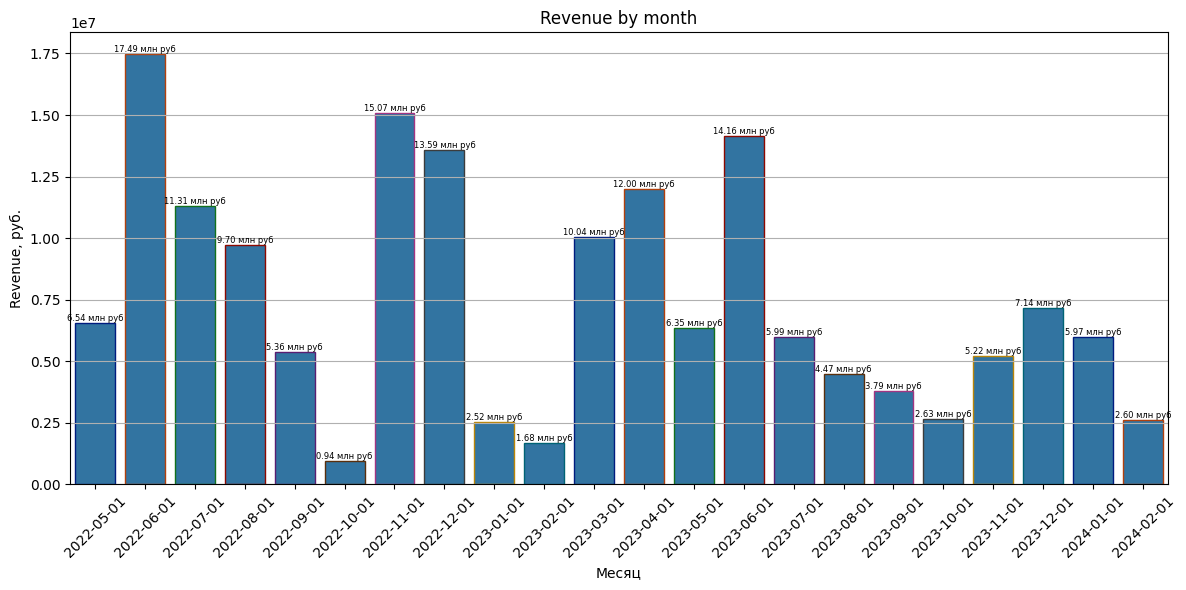

In [60]:
plot_bar_chart('revenue', 
                title='Revenue by month', ylabel='Revenue')

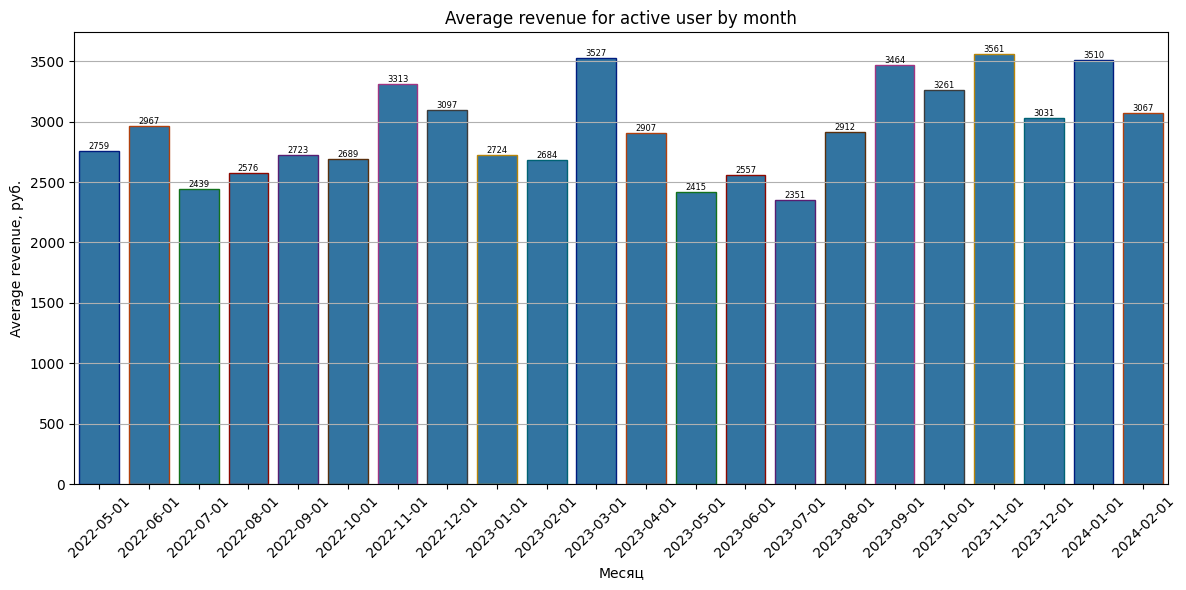

In [61]:
plot_bar_chart('active_revenue_avg', 
                title='Average revenue for active user by month', 
                ylabel='Average revenue')

Стоит отметить, что июнь это топ-1 и топ-3 месяц по выручке. Возможно это связано что основная часть категории товаров относится к летнему периоду.<br/>
Средняя выручка распределена более стабильно по месяцам для активного пользователя, в последнее время видится небольшое увеличение среднего чека. 

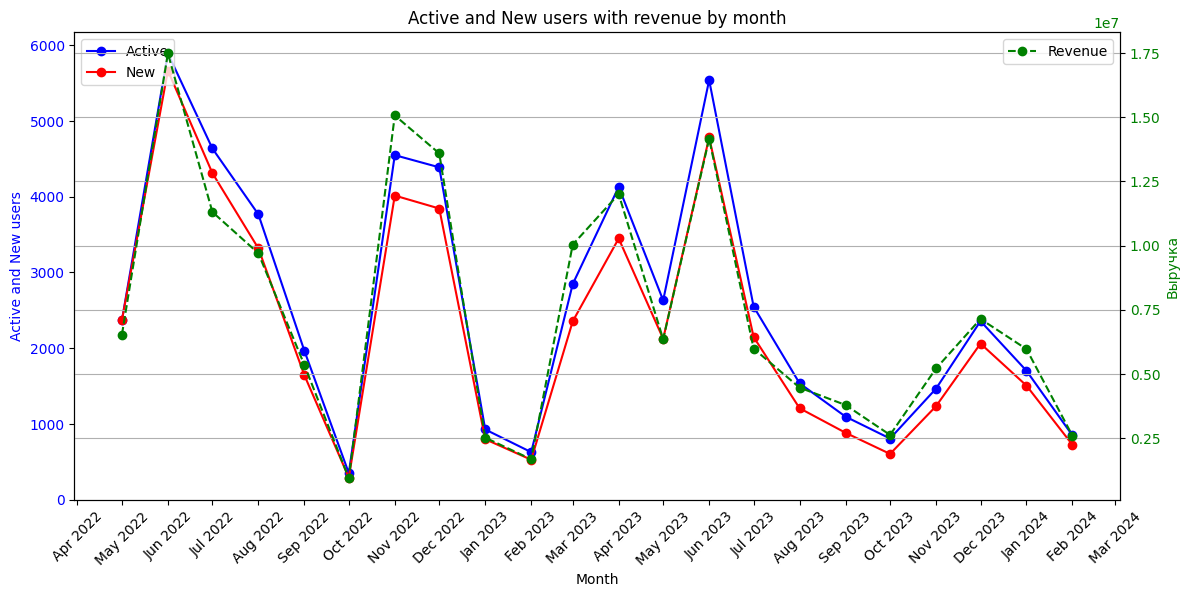

In [62]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Month')
ax1.set_ylabel('Active and New users', color='b')
ax1.plot(t['month'], t['active'], marker='o', linestyle='-', 
         color='b', label='Active')
ax1.plot(t['month'], t['new'], marker='o', linestyle='-', 
         color='r', label='New')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
ax1.xaxis.set_major_locator(mdates.MonthLocator())  
ax1.set_ylim(bottom=0)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Выручка', color='g')
ax2.plot(t['month'], t['revenue'], marker='o', linestyle='--', 
         color='g', label='Revenue')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Active and New users with revenue by month')
plt.grid()
plt.legend()
plt.show()

Графики для активных и новых пользователей, а также их выручки соблюдает единый тренд. 

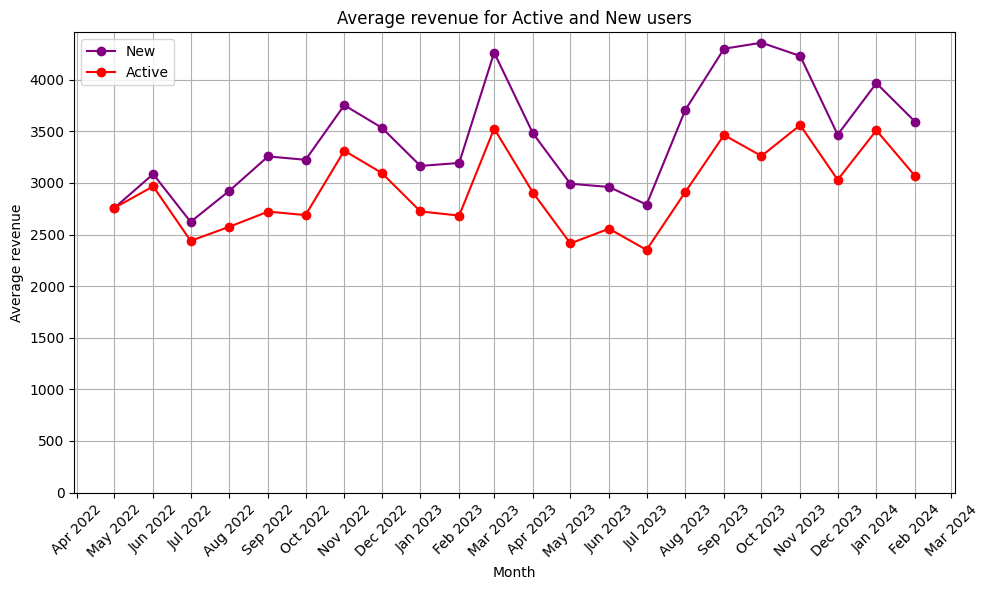

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

# Построение графика
ax.plot(t['month'], t['new_revenue_avg'], marker='o', 
        color='purple', label ='New')
ax.plot(t['month'], t['active_revenue_avg'], marker='o', 
        color='red', label='Active')
ax.set_title('Average revenue for Active and New users')
ax.set_xlabel('Month')
ax.set_ylabel('Average revenue')
ax.set_ylim(bottom=0)
ax.legend(loc='upper left')

# Форматирование меток по оси X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
ax.xaxis.set_major_locator(mdates.MonthLocator())  
plt.xticks(rotation=45) 

plt.grid()
plt.tight_layout()
plt.show()

Средняя выручка на нового и активного пользователя также сохраняет единый тренд, но средняя выручка нового пользователя при этом чуть больше.

In [64]:
def show_scatter(df, col, col2):
    """
    Функция для построения диаграммы рассеяния.

    :param df: Датафрейм
    :param col: Признак 1
    :param col2: Признак 2 
    """
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,6))
    ax1 = sns.scatterplot(x=col, y='revenue', data=df, alpha=0.5, ax=ax[0])
    ax1.set_title('Scatterplot for Revenue and ' + col.title())
    ax2 = sns.scatterplot(x=col2, y='revenue', data=df, alpha=0.5, ax=ax[1])
    ax2.set_title('Scatterplot for Revenue and ' + col2.title())
    plt.tight_layout()

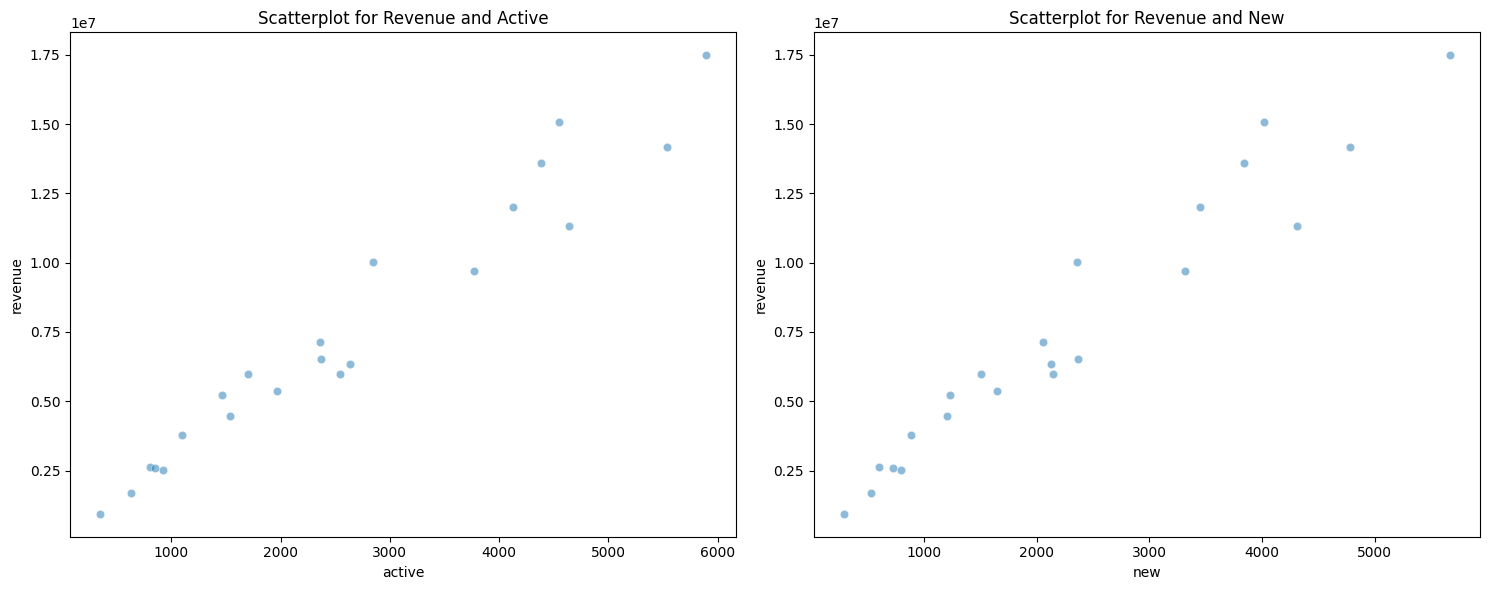

In [65]:
show_scatter(t, 'active', 'new')

С увеличением новых и активных пользователей выручка растет.

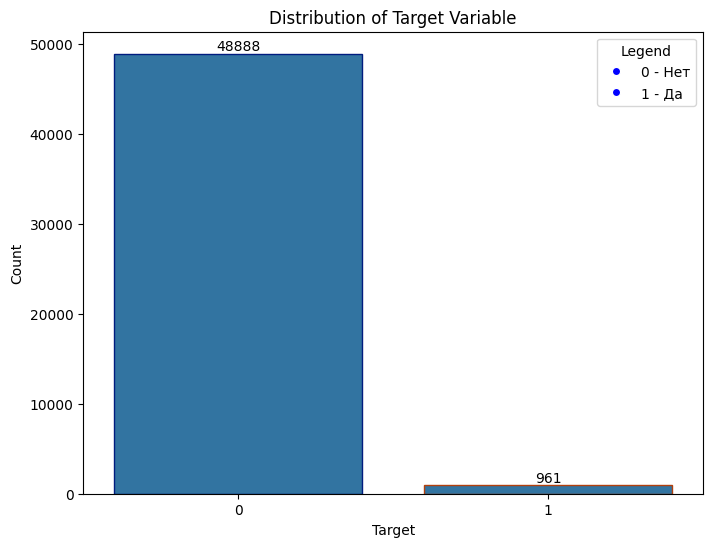

In [66]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=dft, edgecolor=sns.color_palette("dark"))
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')

labels = ['0 - Нет', '1 - Да']

handles = ([plt.Line2D([0], [0], marker='o', color='w', 
                       label=label, markerfacecolor='blue') 
            for label in labels])

ax.legend(handles=handles, title='Legend')
for container in ax.containers :
    ax.bar_label(container)
plt.show()

In [67]:
def show_piegraph(df, ax, col):
    """
    Функция для построения диаграммы типа pie.

    :param df: Датафрейм
    :param ax: Выбор оси для графика
    :param col: Признак
    
    """
    count = df[col].value_counts().iloc[0:5]
    explode = tuple([0.3] + [0.2] + [0] * (len(count)-2))
    ax.pie(count,
    labels = count.index,
    autopct = '%1.1f%%',
    shadow = True,
    explode=explode, radius=0.8)
    ax.set_title('Distribution of values for feature - ' + col)
    ax.set_ylabel('')


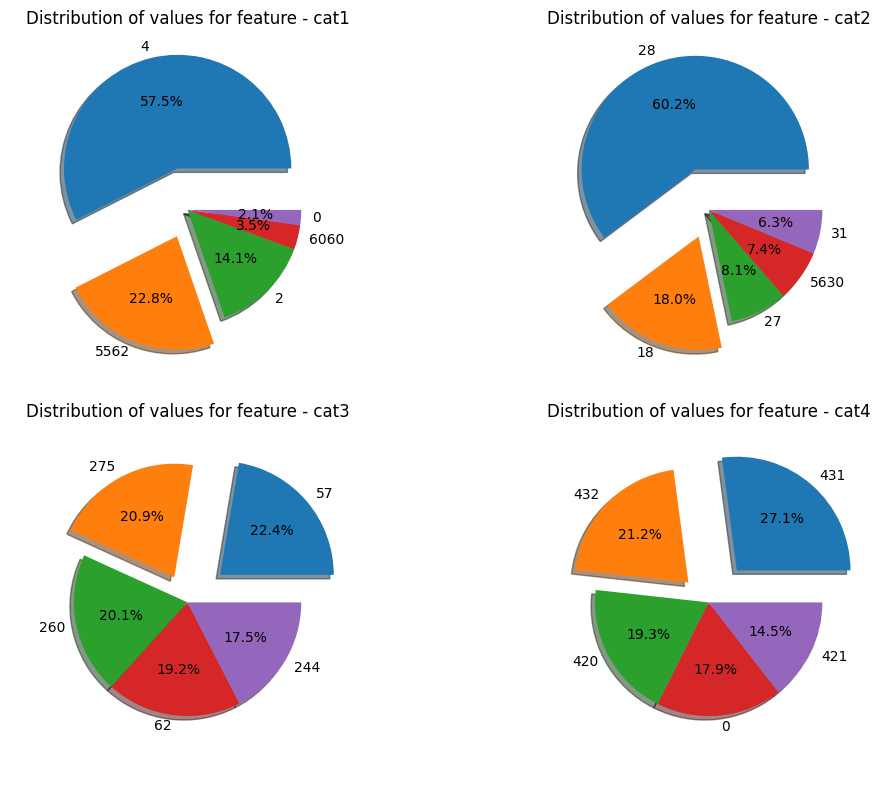

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, col in zip(axes, ['cat1', 'cat2', 'cat3', 'cat4']):
    show_piegraph(dfp, ax, col)
plt.tight_layout()  
plt.show()

На четвертую категорию приходится почти 58% от всех покупок.

In [69]:
def show_hist_box(col):
    """
    Функция для построения столбчатой диаграммы.

    :param col: Признак
    """
    fig, axes = plt.subplots(nrows=2,
                           ncols=1,
                           gridspec_kw = {'height_ratios': (.3, .7)})
    sns.histplot(data = dfp[col], ax = axes[1], bins=50)
    sns.boxplot(x = dfp[col], ax = axes[0])
    axes[1].set_title('Distribution for feature ' + col, fontsize = 12)
    axes[0].set_title('Boxplot for feature ' + col, fontsize = 12)
    axes[1].axvline(dfp[col].mean(), c="r", label='Average')
    axes[1].axvline(dfp[col].median(), c="r", ls="--", label='Median')
    axes[1].set_ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

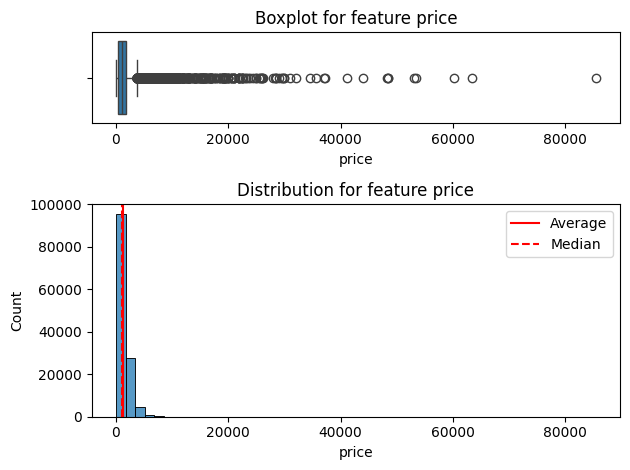

In [70]:
show_hist_box('price')

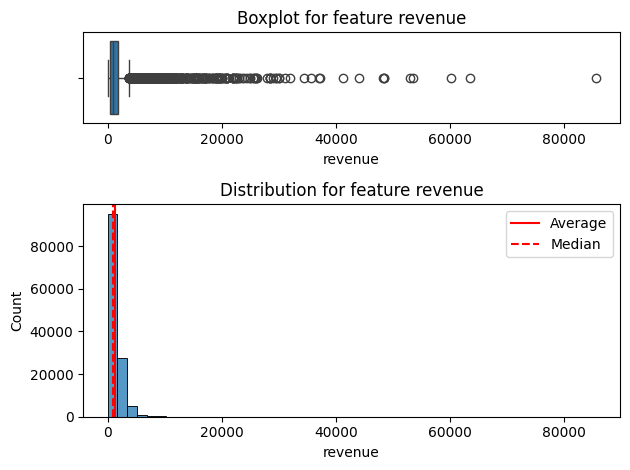

In [71]:
show_hist_box('revenue')

Выручка, как и цена, сконцентрированы около 1000 руб., но стоит отметить единичные покупки стоимостью более 60 тыс. руб.

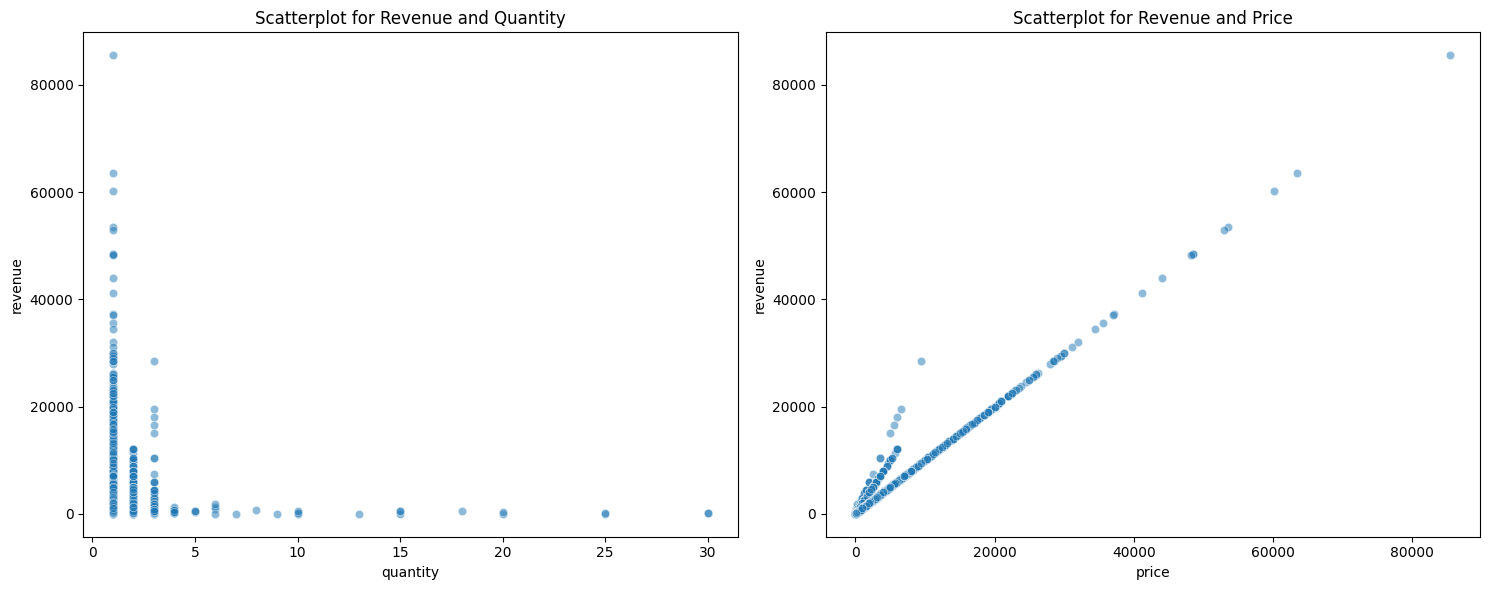

In [72]:
show_scatter(dfp, 'quantity', 'price')

С увеличением цены растет и выручка, но увеличение количества товаров не влияет на выручку, возможно покупалось много товаров по низкой цене.

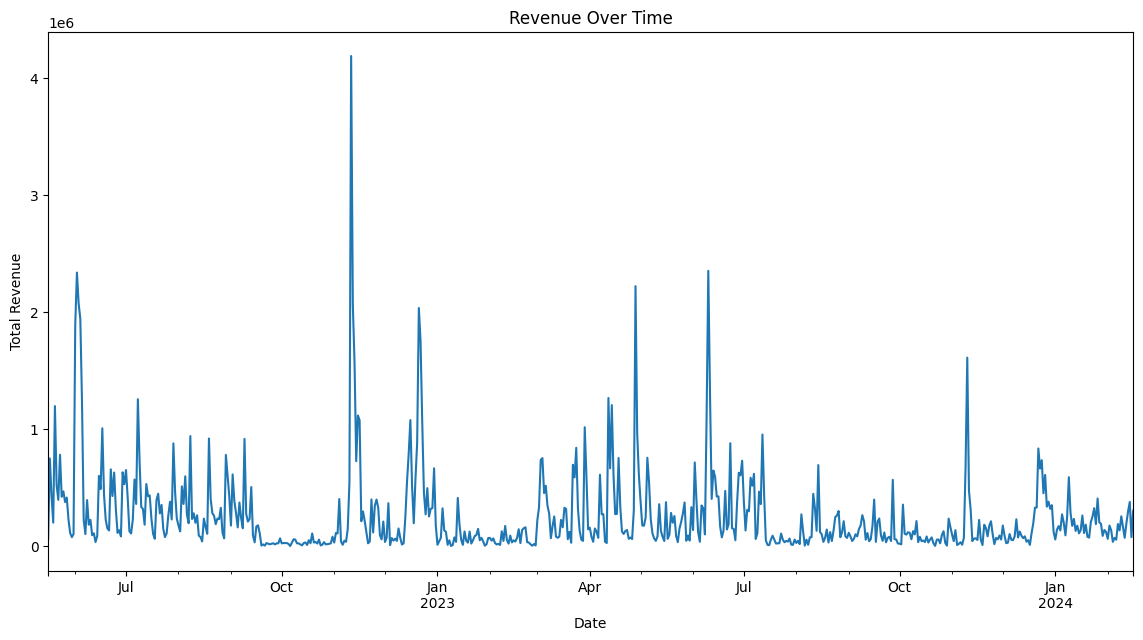

In [73]:
plt.figure(figsize=(14, 7))
dfp.groupby('date')['revenue'].sum().plot()
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.show()

In [74]:
def rev_cat(col, title):
    """
    Функция для построения столбчатого графика
    и выручки.

    :param col: Признак
    :param title: Заголовок графика
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    sns.countplot(x='cat1', data=dfp, order=dfp['cat1'].value_counts().index, 
                  ax=ax1, edgecolor=sns.color_palette("dark"))
    ax1.set_title('Distribution of Categories (cat1) and ' + title)
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Count')
    
    ax2 = ax1.twinx()
    
    if col == 'sum':
        revenue_by_category = (dfp.groupby('cat1')['revenue'].sum()
                               .reindex(dfp['cat1'].value_counts().index))
    else:
        revenue_by_category = (dfp.groupby('cat1')['revenue'].mean()
                               .reindex(dfp['cat1'].value_counts().index))
    ax2.plot(revenue_by_category.index, revenue_by_category, color='red', 
             marker='o', linestyle='-', linewidth=2, label='Revenue')
    ax2.set_ylabel('Revenue', color='red')
    
    if col == 'sum':
        for i, value in enumerate(revenue_by_category):
            ax2.text(revenue_by_category.index[i], value, f'{value / 1_000_000:.1f} млн', 
                     color='red', ha='center', va='bottom')
    else:
        for i, value in enumerate(revenue_by_category):
            ax2.text(revenue_by_category.index[i], value, f'{value:.2f}', color='red', 
                     ha='center', va='bottom')
        
    ax2.legend(loc='upper right')
    
    plt.show()

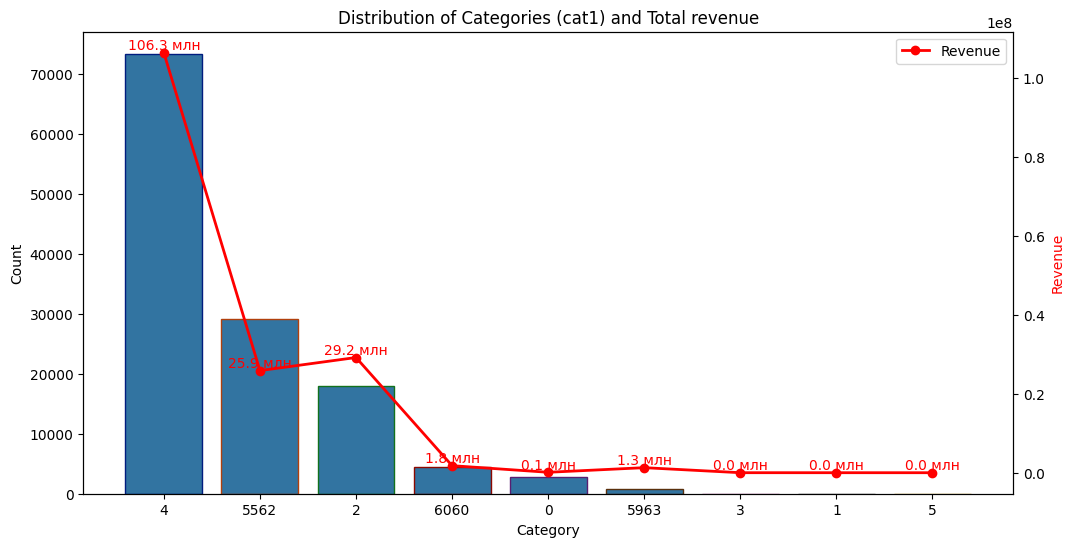

In [75]:
rev_cat('sum', 'Total revenue')

Количество покупок по 4 категории превышает остальные больше чем в два раза, эта категория и принесла наибольшее количество выручки. <br/>
При этом, несмотря на меньшее количество покупок для категории 2, выручка по ней больше, это говорит о том, что товары этой категории стоят дороже. <br/>

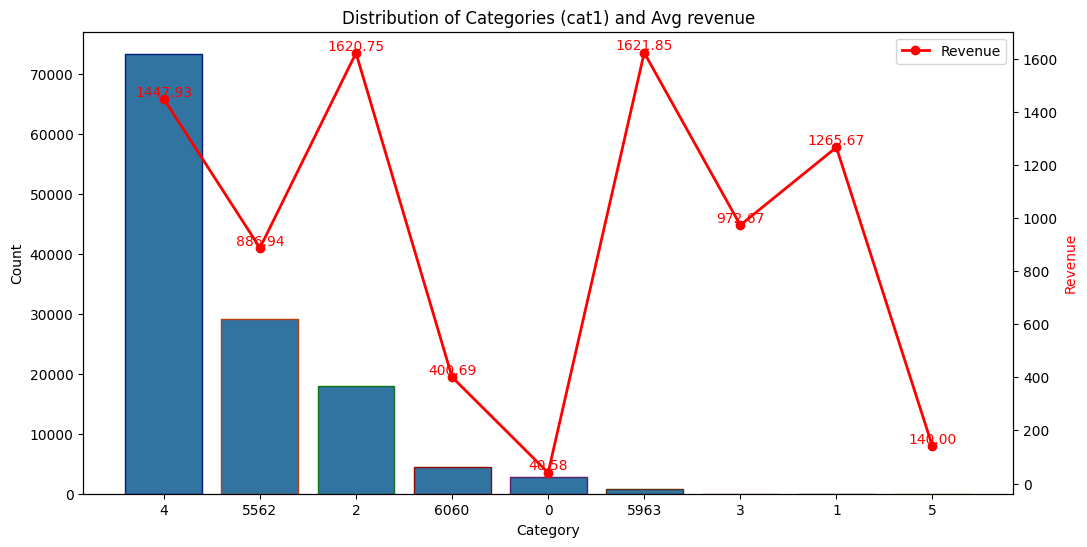

In [76]:
rev_cat('mean', 'Avg revenue')

Средняя выручка по 4 категории при этом не самая высокая, наибольшая средняя выручка у категории 2 и у категории 5963.

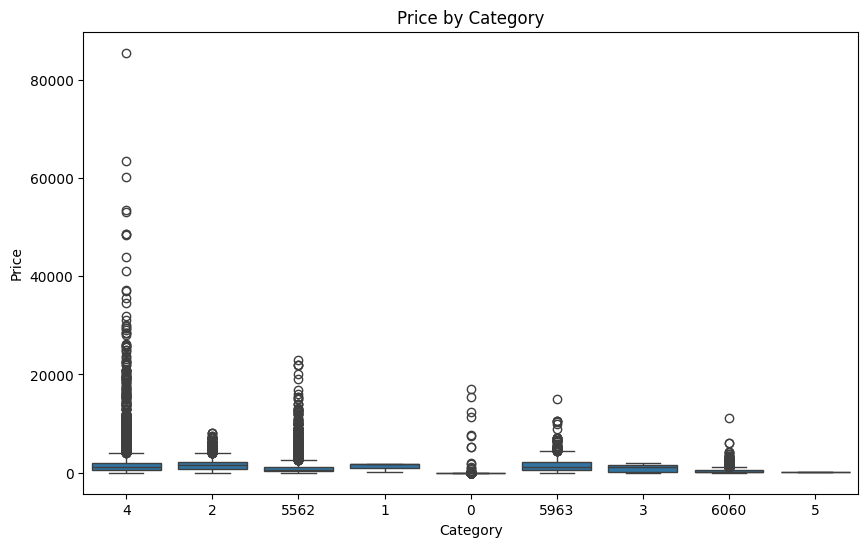

In [77]:
g = dfp.groupby('client_id')['price'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.boxplot(x='cat1', y='price', data=dfp)
plt.title('Price by Category')
plt.xlabel('Category')
plt.ylabel('Price')
plt.show()

Цена для 4 категории также имеет наибольший разброс. 

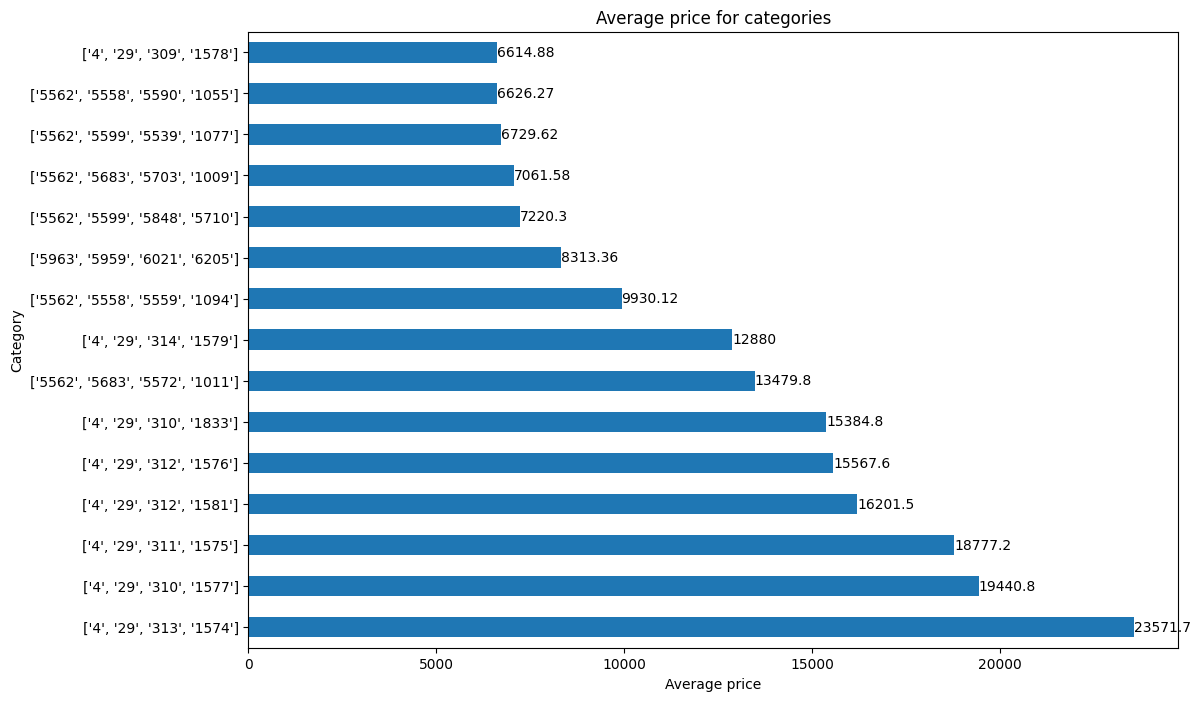

In [78]:
plt.figure(figsize=(12, 8))
category_avg_price = (dfp.groupby('category_ids')['price'].mean()
                      .sort_values(ascending=False)[:15])
ax = category_avg_price.plot(kind='barh')
plt.title('Average price for categories')
plt.xlabel('Average price')
plt.ylabel('Category')
for container in ax.containers :
    ax.bar_label(container)
plt.show()

Наибольшая средняя цена у позиции товара [4, 29, 313, 1574]

In [79]:
def rev_cat_ids(col, title):
    """
    Функция для построения столбчатого графика
    и выручки.

    :param col: Признак
    :param title: Заголовок графика
    """
    category_counts = dfp['category_ids'].value_counts()
    if col == 'sum':
        category_revenue = dfp.groupby('category_ids')['revenue'].sum()
    else:
        category_revenue = dfp.groupby('category_ids')['revenue'].mean()
    
    top_categories = category_counts.head(15).index
    top_counts = category_counts.loc[top_categories]
    top_revenue = category_revenue.loc[top_categories]

    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    sns.barplot(x=top_counts.index, y=top_counts.values, ax=ax1,
                edgecolor=sns.color_palette("dark"))
    ax1.set_xlabel('Category ID')
    ax1.set_ylabel('Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_title('Top 15 Categories by Count and ' + title)
    
    
    ax2 = ax1.twinx()
    ax2.plot(top_revenue.index, top_revenue.values, color='red', 
             marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Revenue, rub', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    if col == 'sum':
        for i, value in enumerate(top_revenue):
                    ax2.text(top_revenue.index[i], value, f'{value / 1_000_000:.1f} млн', 
                             color='red', ha='center', va='bottom')
    else:
        for i, value in enumerate(top_revenue):
                    ax2.text(top_revenue.index[i], value, f'{value:.2f}', color='red', 
                             ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.show()

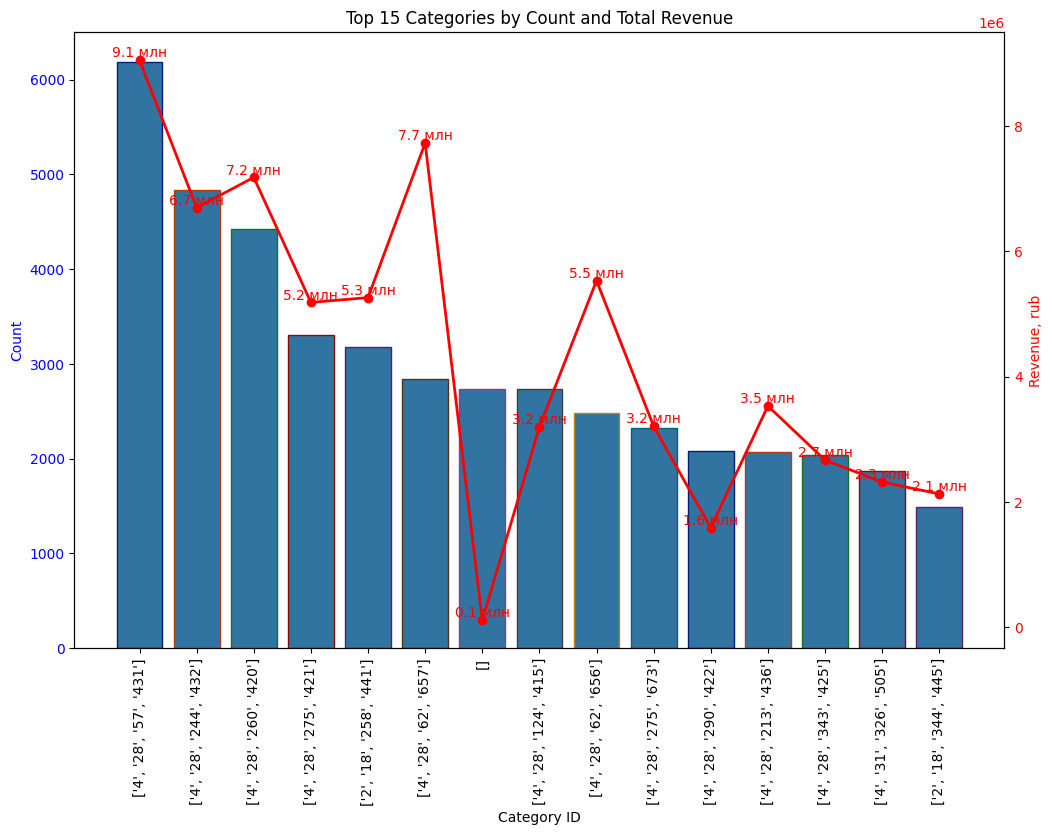

In [80]:
rev_cat_ids('sum', 'Total Revenue')

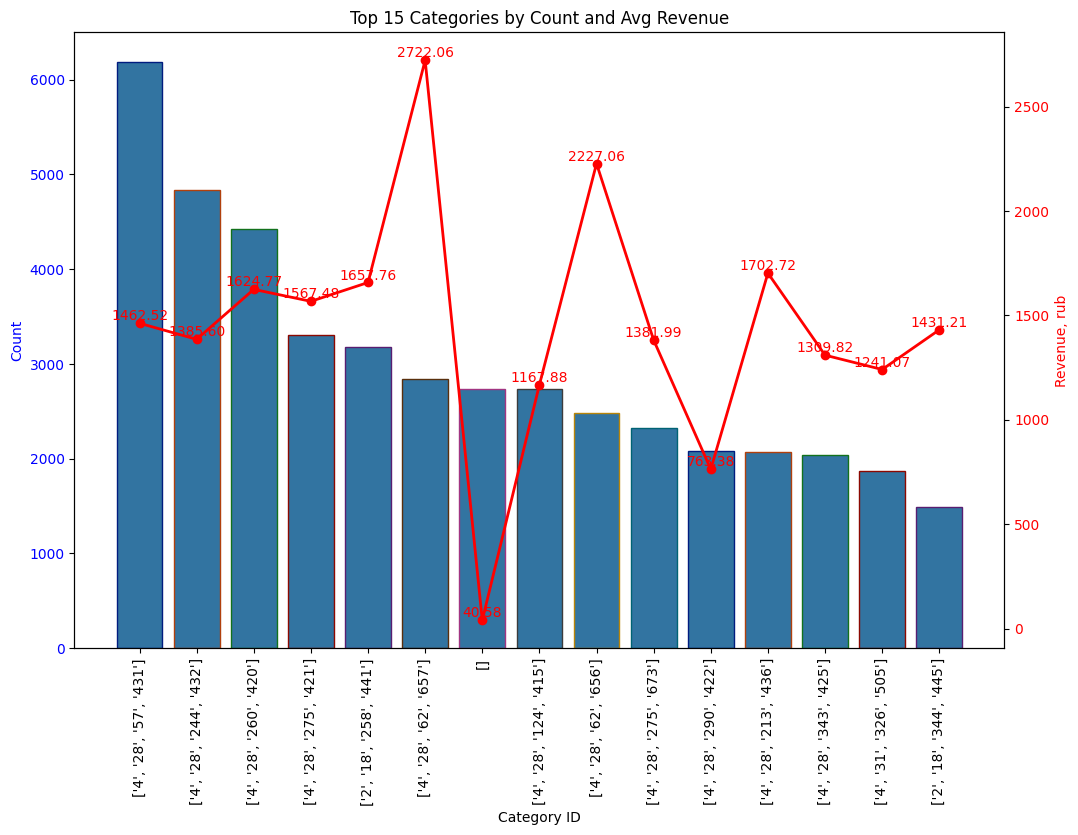

In [81]:
rev_cat_ids('mean', 'Avg Revenue')

Графики показывают что не всегда наиболее популярные категории приносят наибольшую выручку, в первую очередь за счет увеличенной средней цены других категорий.

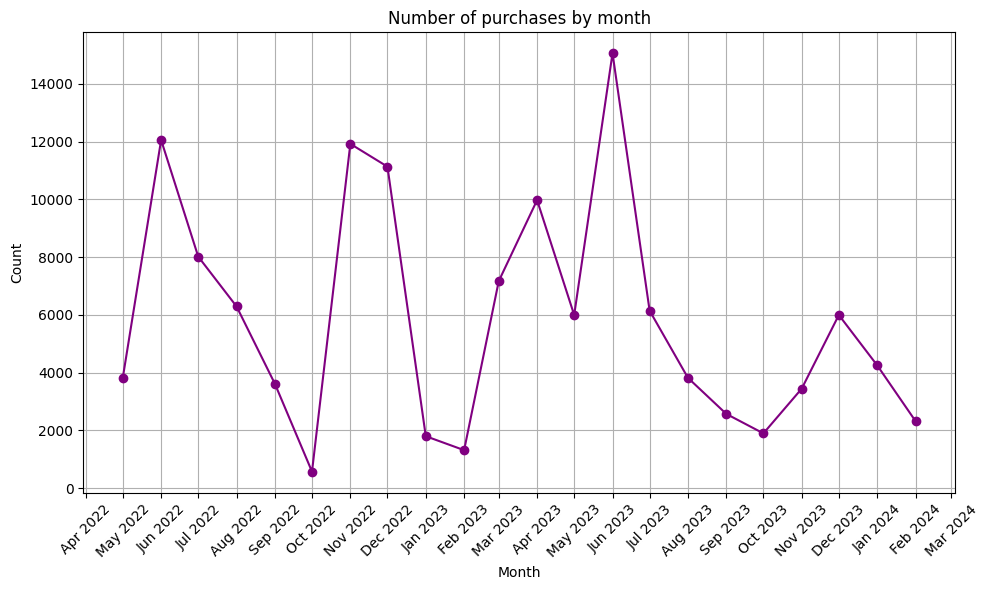

In [82]:
monthly_orders = dfp.groupby('month').size()
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t['month'], monthly_orders, marker='o', color='purple')
ax.set_title('Number of purchases by month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
ax.xaxis.set_major_locator(mdates.MonthLocator())  
plt.xticks(rotation=45)  

plt.grid()
plt.tight_layout()
plt.show()

In [83]:
def show_piegraph(df, ax, col):
    """
    Функция для построения диаграммы типа pie.

    :param df: Датафрейм
    :param ax: Выбор оси для графика
    :param col: Признак
    
    """
    count = df[col].value_counts().iloc[0:3]
    explode = tuple([0.3] + [0.2] + [0] * (len(count)-2))
    ax.pie(count,
    labels = count.index,
    autopct = '%1.1f%%',
    shadow = True,
    explode=explode, radius = 0.85)
    ax.set_title('Distribution of values for feature - ' + col)
    ax.set_ylabel('')

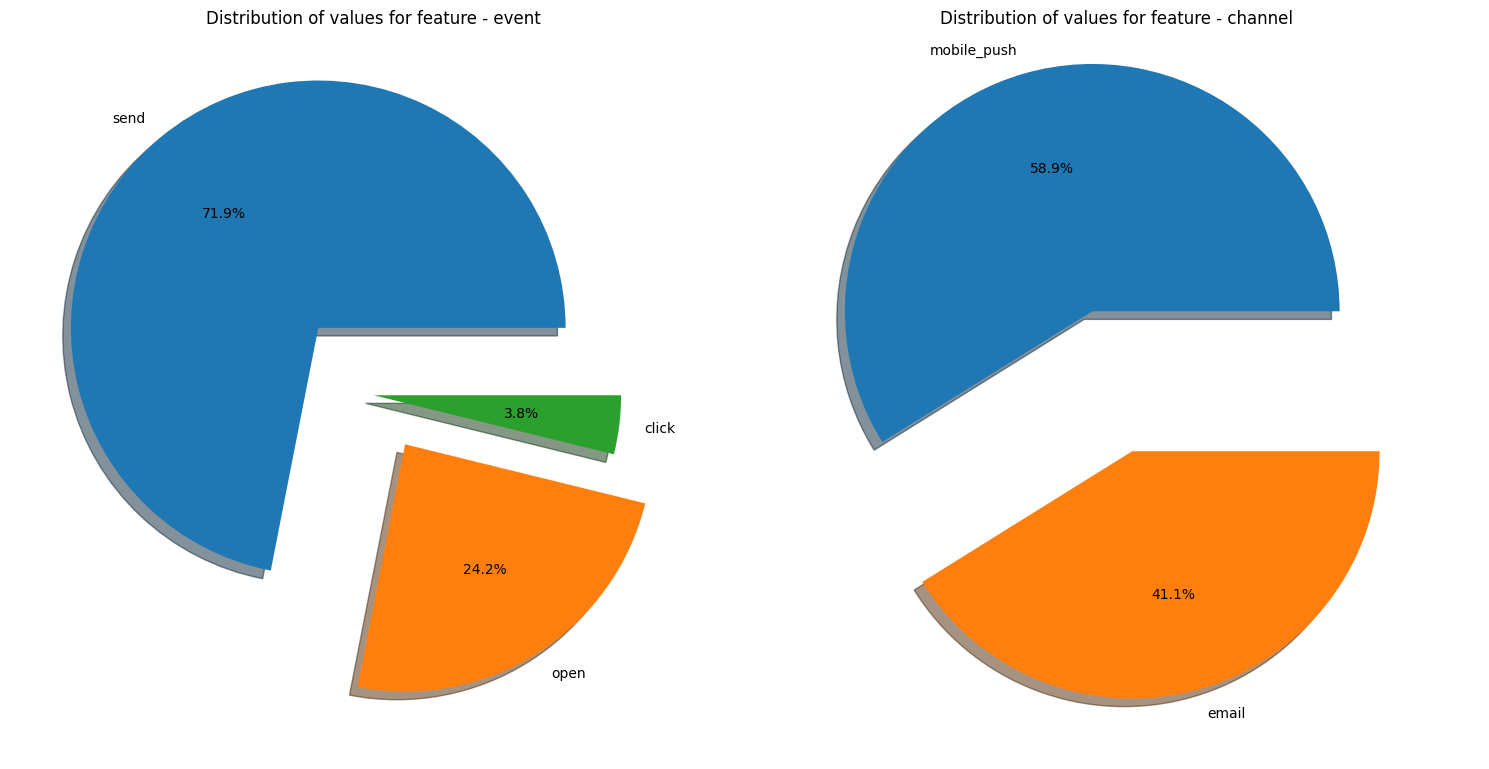

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.ravel()
for ax, col in zip(axes, ['event', 'channel']):
    show_piegraph(dfm, ax, col)
plt.tight_layout()  
plt.show()

Наибольшее количество отправленных сообщений имеют статус *send* (72%), и наиболее предпочтительный вариант отправки сообщений - *mobile_push*.

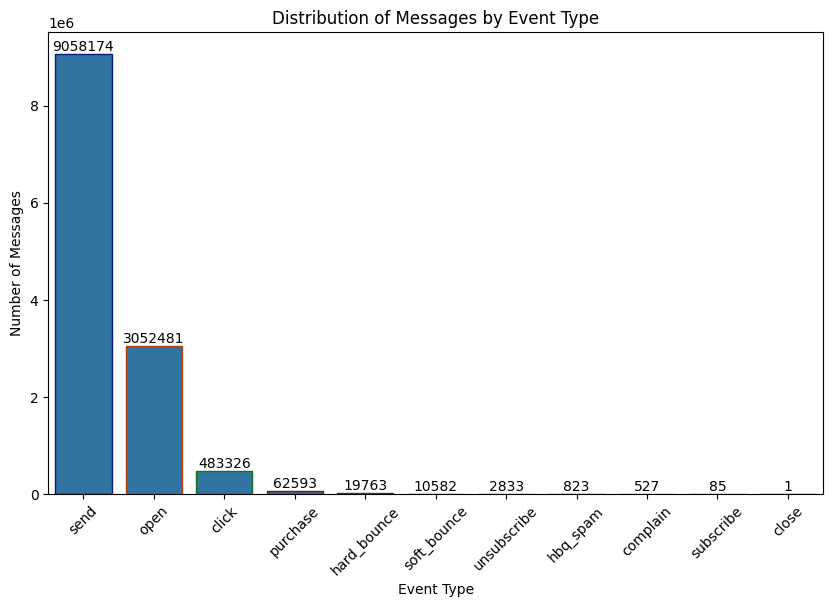

In [85]:
event_counts = dfm['event'].value_counts()

plt.figure(figsize=(10, 6))
ax = (sns.barplot(x=event_counts.index, y=event_counts.values, 
                  edgecolor=sns.color_palette("dark")))
plt.title('Distribution of Messages by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
for container in ax.containers :
    ax.bar_label(container, fmt='%d')
plt.show()

Три наиболее популярных статусов у сообщений - *send*, *open*, *click*. Стоит отмметить что *purchase* не входит в топ3, что говорит о низкой конверсии этих сообщений.

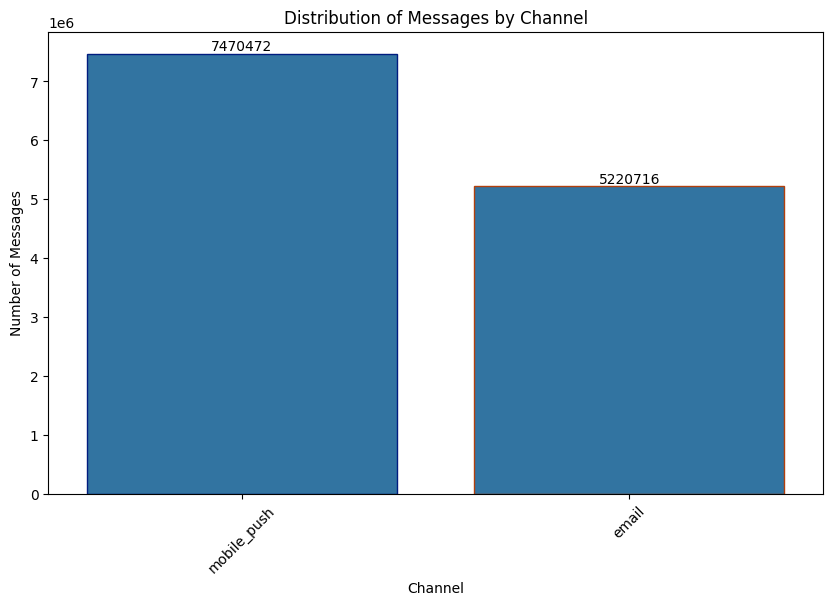

In [86]:
channel_counts = dfm['channel'].value_counts()

plt.figure(figsize=(10, 6))
ax = (sns.barplot(x=channel_counts.index, y=channel_counts.values, 
                  edgecolor=sns.color_palette("dark")))
plt.title('Distribution of Messages by Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
for container in ax.containers :
    ax.bar_label(container, fmt='%d')
plt.show()

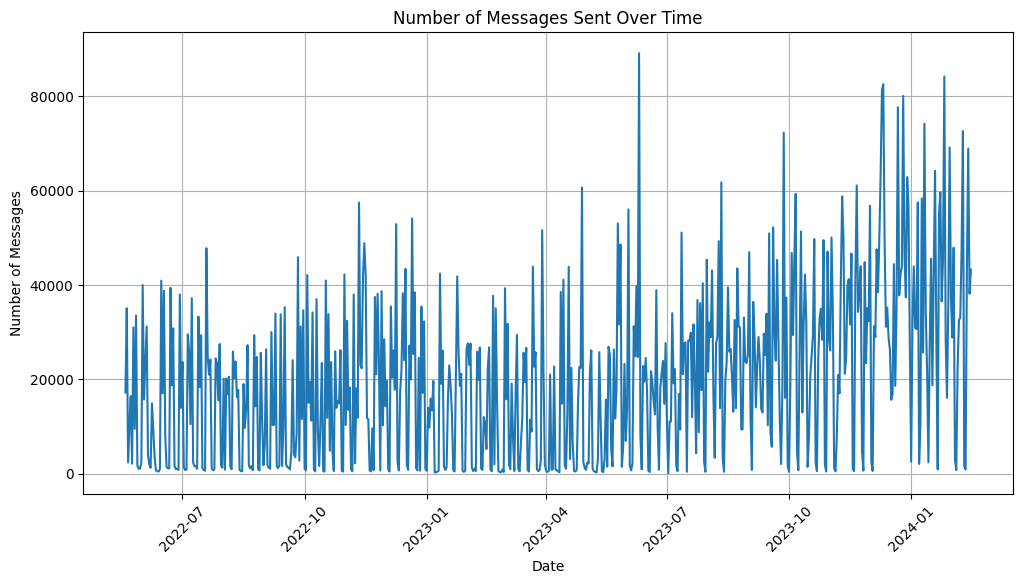

In [87]:
dfm['date'] = pd.to_datetime(dfm['date'])

date_counts = dfm.groupby(dfm['date'].dt.date).size()

plt.figure(figsize=(12, 6))
date_counts.plot(kind='line')
plt.title('Number of Messages Sent Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Можно отметить что количество сообщений увеличивается в последнее время.

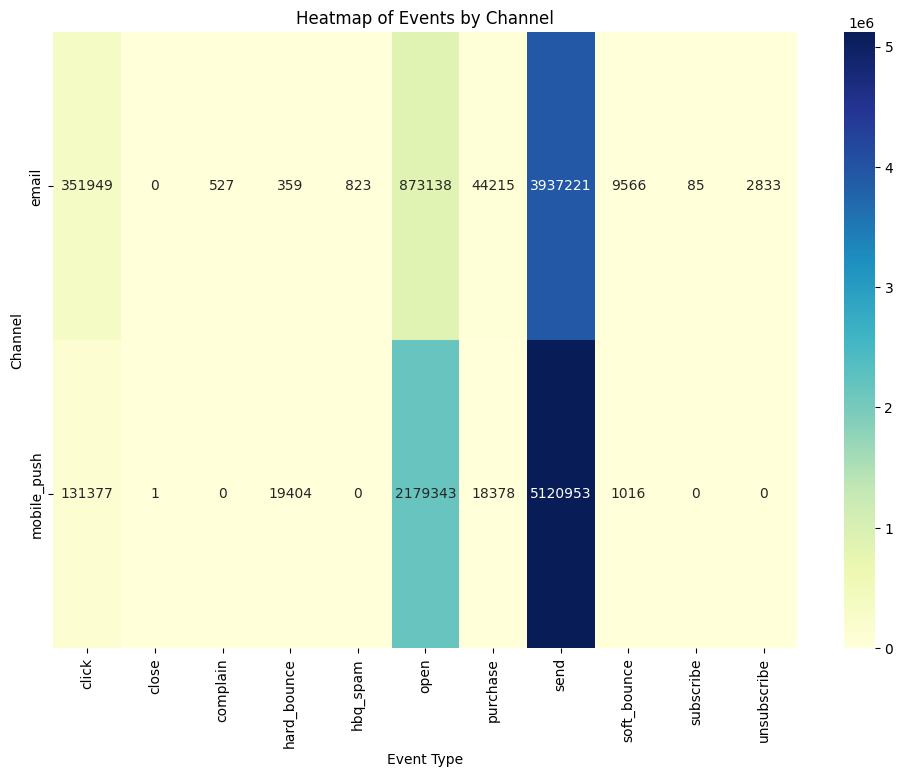

In [88]:
heatmap_data = (dfm.pivot_table(index='channel', columns='event', 
                                values='message_id', aggfunc='count', 
                                fill_value=0))

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Events by Channel')
plt.xlabel('Event Type')
plt.ylabel('Channel')
plt.show()

Несмотря на то, что основной канал отправки сообщений это *mobile_push*, статус *purchase* более чем в два раза лучше у типа связи *email*. 

In [89]:
def show_top15(col, title):
    """
    Функция для построения столбчатой диаграммы.

    :param col: Признак
    """
    event_counts = dfm.groupby([col, 'event']).size().reset_index(name='count')

    total_event_counts = event_counts.groupby(col)['count'].sum().reset_index()
    
    top_15_campaigns = total_event_counts.nlargest(15, 'count')
    
    top_events = event_counts[event_counts[col].isin(top_15_campaigns[col])]
    
    top_events = top_events.sort_values(by='count', ascending=False)
    
    plt.figure(figsize=(12, 8))
    ax = (sns.barplot(data=top_events, x=col, y='count', hue='event', 
                      order=top_events[col].unique()))

    plt.title('Top 15 ' + title + ' by Number of Events (Sorted)')
    plt.xlabel('Bulk Campaign ID')
    plt.ylabel('Number of Events')
    plt.xticks(rotation=45)
    if col == 'channel':
        for container in ax.containers[0:3]:
            ax.bar_label(container, 
                         labels=[f'{v/1000000:.1f} млн' for v in container.datavalues])
    else:
        for container in ax.containers[0:3]:
            ax.bar_label(container, 
                         labels=[f'{v:.0f}' for v in container.datavalues])
    plt.legend(title='Event Type')
    plt.tight_layout()  
    plt.show()

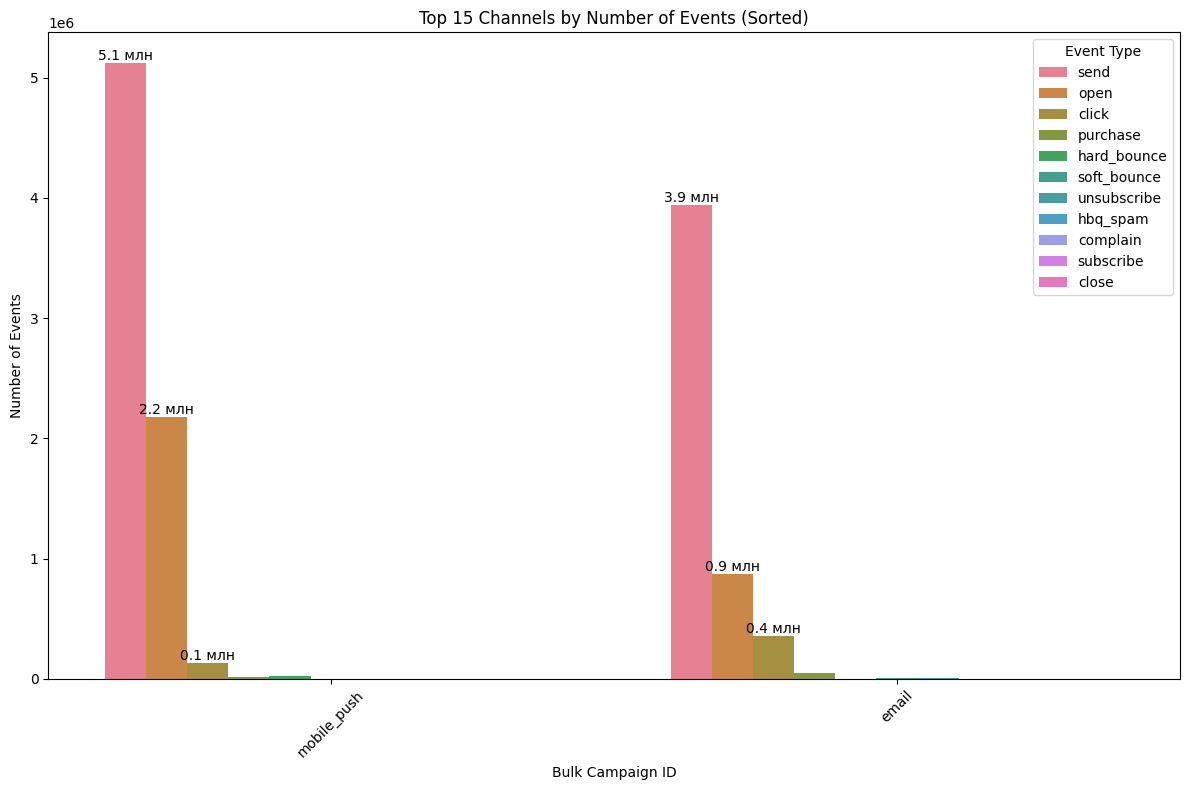

In [90]:
show_top15('channel', 'Channels')

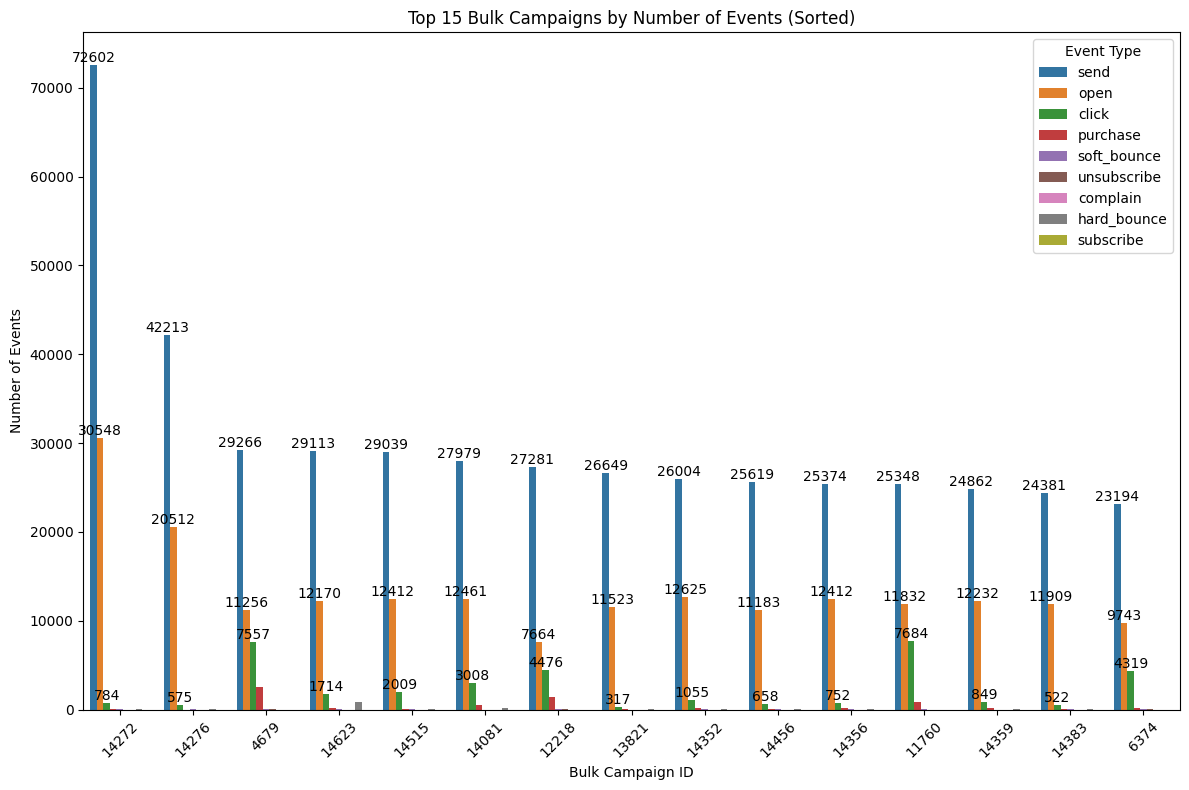

In [91]:
show_top15('bulk_campaign_id', 'Bulk Campaigns')

График показывает что некоторые рекламные компании имеют агрессивный характер и отправляют огромное количество сообщений. Это не всегда эффективно, к примеру, рекламная компания 4679 имеет гораздо лучшую конверсию покупок к количеству отправленных сообщений.

<a id='report_research'></a>
# Предварительный вывод

Для начала исследовательского анализа мы разбили признак `category_ids_` на 5 отдельных категорий и назвали их: `cat1`, `cat2`, `cat3`, `cat4`, `cat5`.<br/>
Затем добавили два новых признака: <br/>
`count_buy_90` - который показывает сколько покупок совершил клиент за последние 90 дней <br/>
`revenue` - который показывает выручку по каждой покупке <br/>
`month` - который показывает первый день месяца покупки <br/>

Затем мы создали новый датафрейм для анализа покупок и построили несколько графиков.
График по выручке показал что июнь это топ-1 и топ-3 месяц по выручке. Возможно это связано что основная часть категории товаров относится к летнему периоду.<br/>
Средняя выручка распределена более стабильно по месяцам для активного пользователя, при этом в последнее время видится небольшое увеличение среднего чека.  <br/>
Графики для активных и новых пользователей, а также их выручки соблюдает единый тренд в котором видится увеличение выручки с увеличением числа клиентов.  <br/>
Средняя выручка на нового и активного пользователя также сохраняет единый тренд, но средняя выручка нового пользователя при этом чуть больше.  <br/>
Диаграмма рессяния показала что с увеличением новых и активных пользователей выручка растет.<br/> 
С увеличением цены растет и выручка, но увеличение количества товаров не влияет на выручку, возможно покупалось много товаров по низкой цене. <br/>
Целевой признак `target` сильно несбалансирован (961 значение против 48888). <br/>
График долей показал что на четвертую категорию приходится почти 58% от всех покупок.  <br/>
Выручка, как и цена, сконцентрированы около 1000 руб., но стоит отметить единичные покупки стоимостью более 40 тыс. руб.<br/>
Количество покупок по 4 категории превышает остальные больше чем в два раза, эта категория и принесла наибольшее количество выручки. <br/>
При этом, несмотря на меньшее количество покупок для категории 2, выручка по ней больше, это говорит о том, что товары этой категории стоят дороже. <br/>
Средняя выручка по 4 категории при этом не самая высокая, наибольшая средняя выручка у категории 2 и у категории 5963, кроме того цена для 4 категории имеет наибольший разброс. <br/>
Наибольшая средняя цена у позиции товара *[4, 29, 313, 1574]*. <br/>
Стоит отметить что не всегда наиболее популярные категории приносят наибольшую выручку, в первую очередь за счет увеличенной средней цены других категорий. <br/>
Наибольшее количество отправленных сообщений имеют статус *send* (72%), и наиболее предпочтительный вариант отправки сообщений - *mobile_push*. <br/>
Три наиболее популярных статусов у сообщений - *send*, *open*, *click*. Стоит отмметить что *purchase* не входит в топ3, что говорит о низкой конверсии этих сообщений. <br/>
Несмотря на то, что основной канал отправки сообщений это *mobile_push*, статус *purchase* более чем в два раза лучше у типа связи *email*. <br/>
График показывает что некоторые рекламные компании имеют агрессивный характер и отправляют огромное количество сообщений. Это не всегда эффективно, к примеру, рекламная компания 4679 имеет гораздо лучшую конверсию покупок к количеству отправленных сообщений. <br/>

<a id='features'></a>
# Работа с признаками

Для обучения модели, сгруппируем датафреймы и объединим их

In [92]:
def most_frequent(series):
    """
    Функция которая находит наиболее частовстречающееся значение

    :param series: Признак
    """
    return series.mode().iloc[0] if not series.mode().empty else None

In [93]:
purchases_agg = dfp.groupby('client_id').agg({
    'client_id': 'count',
    'quantity': 'sum',
    'revenue': 'sum',
    'message_id': 'nunique',
    'date': ['min', 'max'],
    'category_ids': ['nunique'],
    'cat1': most_frequent,
    'cat2': most_frequent,
    'cat3': most_frequent,
    'cat4': most_frequent,
    'cat5': most_frequent,
    'count_buy_90': 'sum'
}).reset_index()

In [94]:
purchases_agg.columns = [
    'client_id', 'client_count', 'quantity_sum',  'revenue_sum',
    'message_id_nunqiue', 'first_date', 'last_date', 
    'category_ids_nunique', 'cat1_most_freq', 'cat2_most_freq', 
    'cat3_most_freq', 'cat4_most_freq', 'cat5_most_freq', 'count_buy_90'
]

In [95]:
col = ['cat1_most_freq', 'cat2_most_freq', 'cat3_most_freq',
       'cat4_most_freq', 'cat5_most_freq'] 
purchases_agg[col] = purchases_agg[col].astype(int)

In [96]:
purchases_agg.shape

(49849, 14)

In [97]:
purchases_agg.sample(5)

client_id  client_count  quantity_sum  \
17757  1515915625491927602             3             3   
2186   1515915625468236136             4             4   
1648   1515915625468191578             7             7   
20332  1515915625502102926            10            10   
18943  1515915625500470718             3             3   

                  revenue_sum  message_id_nunqiue first_date  last_date  \
17757 2297.000000000000000000                   1 2022-07-08 2022-07-08   
2186  4596.000000000000000000                   2 2022-08-08 2022-11-23   
1648  8694.000000000000000000                   1 2023-04-17 2023-04-17   
20332 3834.000000000000000000                   1 2023-07-12 2023-07-12   
18943 2897.000000000000000000                   1 2023-06-10 2023-06-10   

       category_ids_nunique  cat1_most_freq  cat2_most_freq  cat3_most_freq  \
17757                     3               2              18             267   
2186                      3               4              28            5692   
1648                      2               2              18             258   
20332                     8               4            1822            1824   
18943                     2               2              18             123   

       cat4_most_freq  cat5_most_freq  count_buy_90  
17757            1330               0             0  
2186              637               0             0  
1648              441               0             0  
20332            1620               0             0  
18943             451               0             0

Добавим признак `avg_price` и `success`

In [98]:
purchases_agg['avg_price'] = purchases_agg['revenue_sum'] / purchases_agg['quantity_sum']

In [99]:
messages_agg = dfm.groupby('client_id').agg({
    'bulk_campaign_id': 'nunique',
    'message_id': 'nunique',
    'date': ['min', 'max', 'count']
}).reset_index()

In [100]:
messages_agg.columns = [
    'client_id', 'bulk_campaign_id_nunique', 'message_id_nunqiue_m', 
    'first_date_m', 'last_date_m', 'count_date_m'
]

Объединим датафреймы по ключу `client_id`

In [101]:
df = purchases_agg.merge(messages_agg, on='client_id', how='left')

In [102]:
df = df.merge(dft, on='client_id', how='left')

Посчитаем количество событий и количество каналов для каждого клиента в отдельности

In [103]:
dummies_events = (pd.get_dummies(dfm[['client_id', 'event']], 
                                 columns=['event'], drop_first=True))

In [104]:
dummies_channels = (pd.get_dummies(dfm[['client_id', 'channel']], 
                                   columns=['channel'], drop_first=True))

In [105]:
grouped_events = dummies_events.groupby('client_id').sum().reset_index()

In [106]:
grouped_events.head()

client_id  event_close  event_complain  event_hard_bounce  \
0  1515915625468060902            0               0                  0   
1  1515915625468061003            0               0                  0   
2  1515915625468061099            0               0                  2   
3  1515915625468061100            0               0                  1   
4  1515915625468061170            0               0                  0   

   event_hbq_spam  event_open  event_purchase  event_send  event_soft_bounce  \
0               0          35               5         126                  0   
1               0           5               1         154                  0   
2               0          51               0         215                  0   
3               0         157               1         267                  1   
4               0          31               3         243                  0   

   event_subscribe  event_unsubscribe  
0                0                  1  
1                0                  0  
2                0                  0  
3                0                  0  
4                0                  0

In [107]:
grouped_channels = dummies_channels.groupby('client_id').sum().reset_index()

In [108]:
grouped_channels.head()

client_id  channel_mobile_push
0  1515915625468060902                    0
1  1515915625468061003                    0
2  1515915625468061099                   94
3  1515915625468061100                  428
4  1515915625468061170                   91

Добавим эти признак к общему датаферйму объединив их также по ключу `client_id`

In [109]:
dummies_df = pd.merge(grouped_events, grouped_channels, on='client_id', how='inner')

In [110]:
df = df.merge(dummies_df, on='client_id', how='left')

In [111]:
df.tail(5)

client_id  client_count  quantity_sum  \
49844  1515915626010261344             1             1   
49845  1515915626010266132             1             1   
49846  1515915626010439406             1             1   
49847  1515915626010443527             1             1   
49848  1515915626010443624             1             1   

                  revenue_sum  message_id_nunqiue first_date  last_date  \
49844 1499.000000000000000000                   1 2024-02-16 2024-02-16   
49845  909.000000000000000000                   1 2024-02-14 2024-02-14   
49846   99.000000000000000000                   1 2024-02-16 2024-02-16   
49847 1999.000000000000000000                   1 2024-02-16 2024-02-16   
49848  999.000000000000000000                   1 2024-02-16 2024-02-16   

       category_ids_nunique  cat1_most_freq  cat2_most_freq  ...  \
49844                     1               2              18  ...   
49845                     1               4              27  ...   
49846                     1               4              27  ...   
49847                     1               2              18  ...   
49848                     1               4              28  ...   

            event_complain    event_hard_bounce       event_hbq_spam  \
49844 0.000000000000000000 0.000000000000000000 0.000000000000000000   
49845                  NaN                  NaN                  NaN   
49846                  NaN                  NaN                  NaN   
49847                  NaN                  NaN                  NaN   
49848                  NaN                  NaN                  NaN   

                event_open       event_purchase           event_send  \
49844 1.000000000000000000 0.000000000000000000 1.000000000000000000   
49845                  NaN                  NaN                  NaN   
49846                  NaN                  NaN                  NaN   
49847                  NaN                  NaN                  NaN   
49848                  NaN                  NaN                  NaN   

         event_soft_bounce      event_subscribe    event_unsubscribe  \
49844 0.000000000000000000 0.000000000000000000 0.000000000000000000   
49845                  NaN                  NaN                  NaN   
49846                  NaN                  NaN                  NaN   
49847                  NaN                  NaN                  NaN   
49848                  NaN                  NaN                  NaN   

       channel_mobile_push  
49844 3.000000000000000000  
49845                  NaN  
49846                  NaN  
49847                  NaN  
49848                  NaN  

[5 rows x 32 columns]

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   client_count              49849 non-null  int64         
 2   quantity_sum              49849 non-null  int64         
 3   revenue_sum               49849 non-null  float64       
 4   message_id_nunqiue        49849 non-null  int64         
 5   first_date                49849 non-null  datetime64[ns]
 6   last_date                 49849 non-null  datetime64[ns]
 7   category_ids_nunique      49849 non-null  int64         
 8   cat1_most_freq            49849 non-null  int32         
 9   cat2_most_freq            49849 non-null  int32         
 10  cat3_most_freq            49849 non-null  int32         
 11  cat4_most_freq            49849 non-null  int32         
 12  cat5_most_freq    

Видим что появились пустые строки после присоединения датафрейма messages. Это говорит о том, что эти клиенты осуществляли покупку, но с ними не было взаимодействия через рекламную рассылку, поэтому просто заполним нулями такие значения.

In [113]:
df = df.fillna(0)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   client_count              49849 non-null  int64         
 2   quantity_sum              49849 non-null  int64         
 3   revenue_sum               49849 non-null  float64       
 4   message_id_nunqiue        49849 non-null  int64         
 5   first_date                49849 non-null  datetime64[ns]
 6   last_date                 49849 non-null  datetime64[ns]
 7   category_ids_nunique      49849 non-null  int64         
 8   cat1_most_freq            49849 non-null  int32         
 9   cat2_most_freq            49849 non-null  int32         
 10  cat3_most_freq            49849 non-null  int32         
 11  cat4_most_freq            49849 non-null  int32         
 12  cat5_most_freq    

Построим корреляционные матрицы, перед этим удалим признаки с датой. 

In [115]:
fulldate = (df.drop(['first_date', 'last_date', 
                     'first_date_m', 'last_date_m'], axis=1))

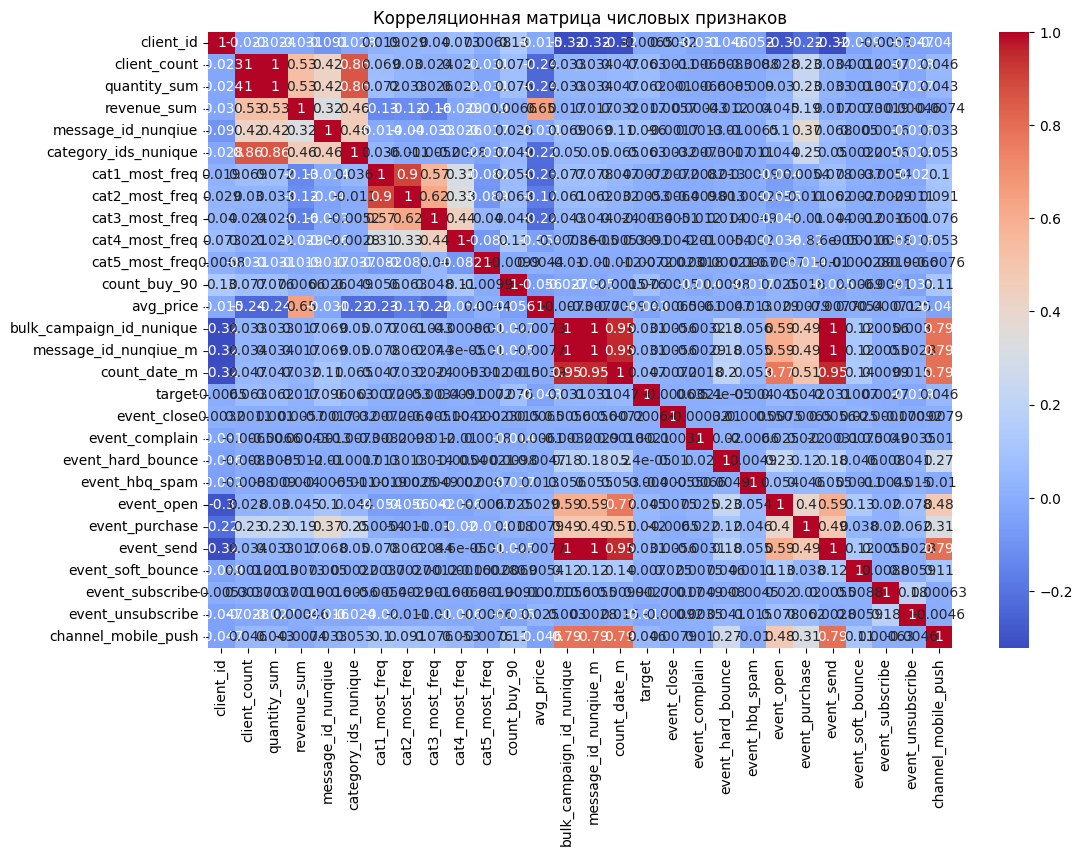

In [116]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(fulldate.corr(method='spearman', numeric_only=True), annot=True, 
            cmap='coolwarm', ax=ax)
plt.title('Корреляционная матрица числовых признаков')
plt.yticks(rotation=0)
plt.show()

In [117]:
interval_cols = ['revenue_sum', 'avg_price']

In [118]:
fulldate = fulldate.drop(['client_id'], axis=1)

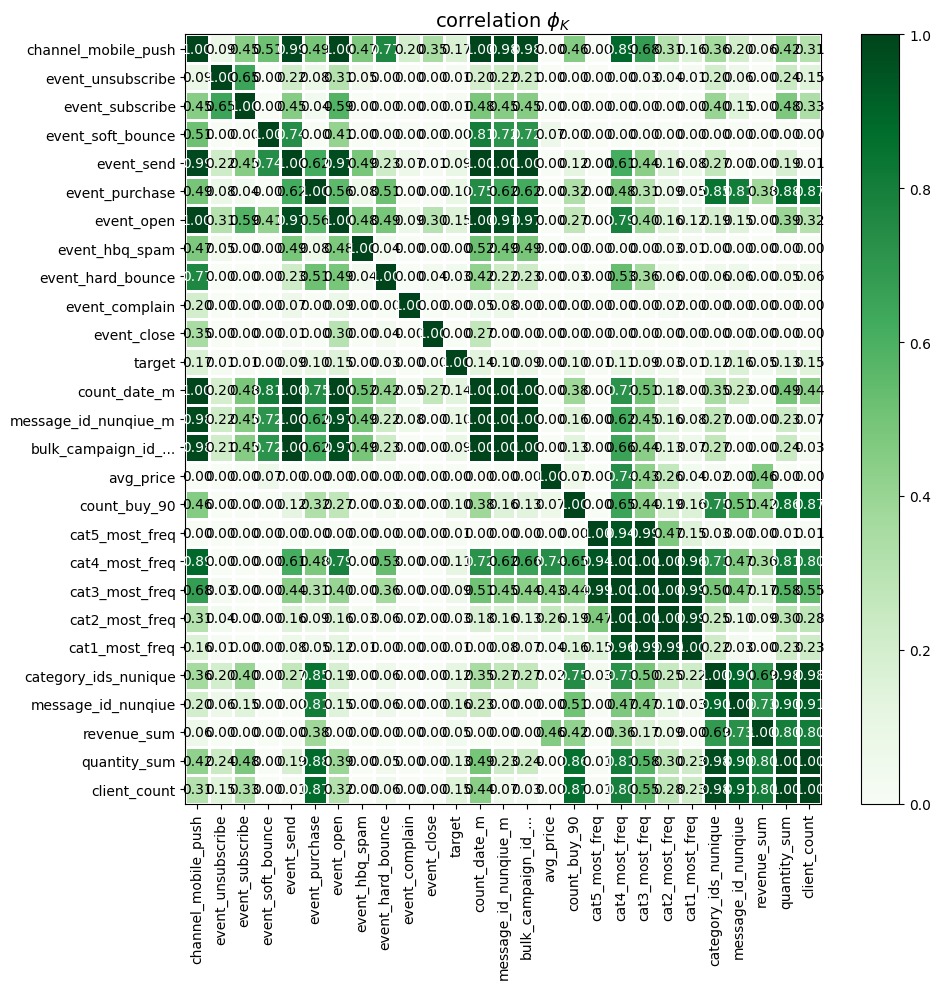

In [119]:
phik_overview = fulldate.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

Очень много признаков с высокой корреляцией, удалим их.

In [120]:
fulldate = (fulldate.drop(['event_close', 'event_complain', 'event_subscribe', 
                           'cat5_most_freq' ,'event_hbq_spam', 'event_soft_bounce', 
                           'event_hard_bounce', 'message_id_nunqiue_m', 'bulk_campaign_id_nunique', 
                           'cat4_most_freq', 'event_send', 'quantity_sum', 'cat2_most_freq'], axis=1))

Посмотрим еще раз на корреляционную матрицу

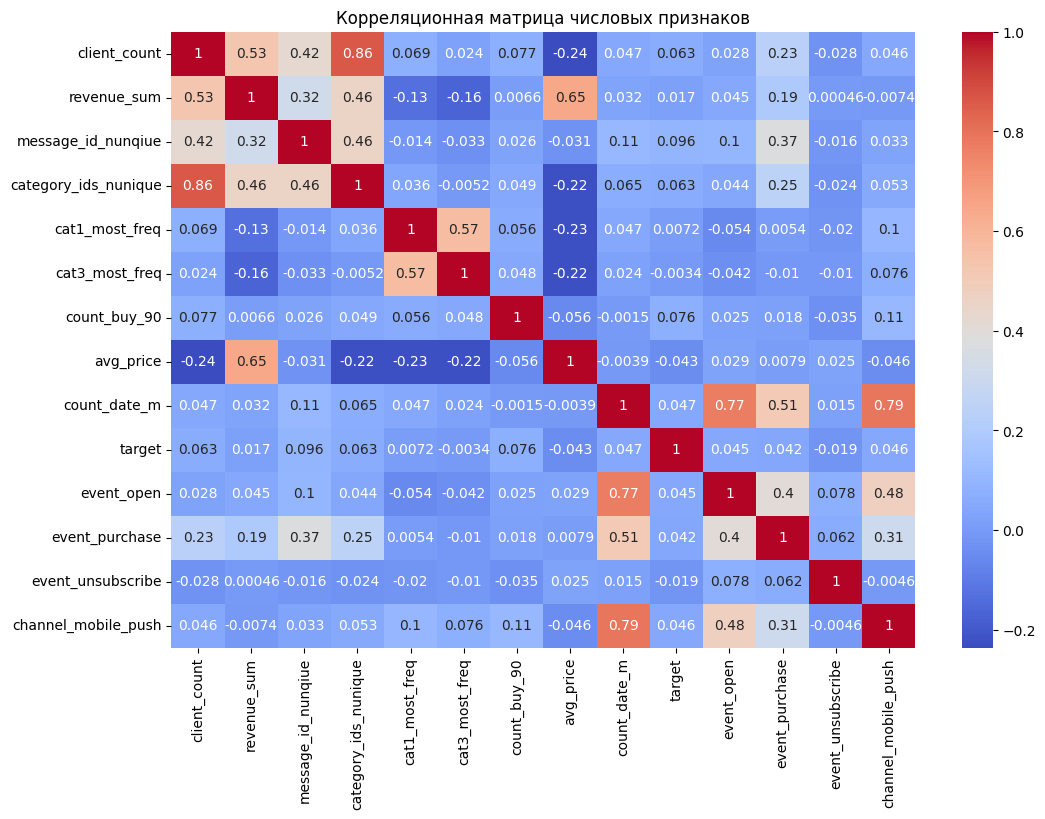

In [121]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(fulldate.corr(method='spearman', numeric_only=True), annot=True, 
            cmap='coolwarm', ax=ax)
plt.title('Корреляционная матрица числовых признаков')
plt.yticks(rotation=0)
plt.show()

Проверим еще на мультиколлинеарность с использованием VIF.

In [122]:
df_vif = fulldate.copy()

In [123]:
def show_vif():
    interval_cols = df_vif.select_dtypes('number').columns.tolist()
    X = add_constant(df_vif[interval_cols])
    vif_data = pd.DataFrame()
    vif_data["Column"] = X.columns
     
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
      
    print(vif_data)

In [124]:
show_vif()

                  Column                   VIF
0                  const 10.145446451701657153
1           client_count  5.593205494676899647
2            revenue_sum  2.649561358699888736
3     message_id_nunqiue  1.771073621307985180
4   category_ids_nunique  4.523604407836235630
5         cat1_most_freq  7.381888650400580509
6         cat3_most_freq  7.391895365038267052
7           count_buy_90  1.123181566478746340
8              avg_price  1.874806018318290635
9           count_date_m  5.701812352857879240
10                target  1.021053726573892151
11            event_open  3.157648754172426742
12        event_purchase  1.648560649228565378
13     event_unsubscribe  1.003868115902790015
14   channel_mobile_push  3.611818591890278540


Наблюдаются высоки значения VIF, особенно у признака `quantity_sum`, но пока сложно сказать достаточно ли оно высокое чтобы говорить о мультиколлинеарности.

In [125]:
fulldate.shape

(49849, 14)

<a id='report_features'></a>
# Предварительный вывод

На данном этапе объединили все датафреймы в один по ключу `client_id`, дополнительно, при группировке, создав следующие признаки: <br/>
- `client_count` - количество заказов у пользователя<br/>
- `quantity_sum` - количество купленных товаров у пользователя<br/>
- `revenue_sum` - выручка<br/>
- `message_id_nunqiue` - количество уникальных сообщений отправленных пользователю<br/>
- `first_date` - минимальная дата покупки<br/>
- `last_date` - последняя дата покупки<br/>
- `category_ids_nunique` - количество купленных уникальных категорий<br/>
- `cat1_most_freq` - наиболее часто встречающаяся категория для `cat1` <br/>
- `cat2_most_freq` - наиболее часто встречающаяся категория для `cat2` <br/>
- `cat3_most_freq` - наиболее часто встречающаяся категория для `cat3` <br/>
- `cat4_most_freq` - наиболее часто встречающаяся категория для `cat4` <br/>
- `cat5_most_freq` - наиболее часто встречающаяся категория для `cat5` <br/>
- `count_buy_90` - количество покупок у клиента за последние 90 дней<br/>
- `bulk_campaign_id_nunique` - количество уникальных рекламных компаний<br/>
- `message_id_nunqiue_m` - количество уникальных сообщений отправленных пользователю<br/>
- `first_date_m` - минимальная дата отправки сообщения клиенту<br/>
- `last_date_m` - максимальная дата отправки сообщения клиенту<br/>
- `count_date_m` - количество дней когда рассылались сообщения<br/>
- `bulk_campaign_id` - количество уникальных рекламных компаний<br/>
- `bulk_campaign_id` - количество уникальных рекламных компаний<br/>

Корреляционная матрица показала нам большое количество коррелирующих признаков, что также подтвердил показатель *variance inflation factor*.  <br/>

После удаления сильно коррелирующих признаков, в нашем датафрейме осталось 49849 строк и 14 признаков.<br/>

<a id='learn'></a>
# Обучение

Перейдем к обучению модели.

In [126]:
fulldate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_count          49849 non-null  int64  
 1   revenue_sum           49849 non-null  float64
 2   message_id_nunqiue    49849 non-null  int64  
 3   category_ids_nunique  49849 non-null  int64  
 4   cat1_most_freq        49849 non-null  int32  
 5   cat3_most_freq        49849 non-null  int32  
 6   count_buy_90          49849 non-null  int32  
 7   avg_price             49849 non-null  float64
 8   count_date_m          49849 non-null  float64
 9   target                49849 non-null  int64  
 10  event_open            49849 non-null  float64
 11  event_purchase        49849 non-null  float64
 12  event_unsubscribe     49849 non-null  float64
 13  channel_mobile_push   49849 non-null  float64
dtypes: float64(7), int32(3), int64(4)
memory usage: 4.8 MB


In [127]:
X = fulldate.drop(['target'], axis=1)
y = fulldate['target']

In [128]:
y.value_counts()

target
0    48888
1      961
Name: count, dtype: int64

In [129]:
X_train, X_test, y_train, y_test = (train_test_split(X, y, test_size=0.3, 
                                                     random_state=RANDOM_STATE, 
                                                     shuffle=True))

В качестве моделей будем использовать *XGBClassifier* и *GradientBoostingClassifier*. Эти модели хорошо работает с количественными признаками и не требуют применения масштабирования.

In [130]:
# Определим параметры для XGBClassifier
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'scale_pos_weight': [1, 2, 3],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0.1, 1, 10],
    'max_bin': [256, 512, 1024]
}

# Определим параметры для GradientBoostingClassifier
param_grid_gbc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создадим экземпляры RandomizedSearchCV для каждой модели
randomized_search_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
    param_distributions=param_grid_xgb,
    scoring='roc_auc',
    cv=5,
    n_iter=300,
    random_state=RANDOM_STATE,
    verbose=10
)

randomized_search_gbc = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=param_grid_gbc,
    scoring='roc_auc',
    cv=3,
    n_iter=100,
    random_state=RANDOM_STATE,
    verbose=10
)

# Обучение моделей
randomized_search_xgb.fit(X_train, y_train)
randomized_search_gbc.fit(X_train, y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5; 1/300] START colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_bin=1024, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=10, scale_pos_weight=3, subsample=1.0
[CV 1/5; 1/300] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_bin=1024, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=10, scale_pos_weight=3, subsample=1.0;, score=0.645 total time=   0.1s
[CV 2/5; 1/300] START colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_bin=1024, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=10, scale_pos_weight=3, subsample=1.0
[CV 2/5; 1/300] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_bin=1024, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=10, scale_pos_weight=3, subsample=1.0;, score=0.654 total time=   0.1s
[CV 3/5; 1/300] START colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_bi

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=10)

In [131]:
# Просмотр лучших параметров и результатов
print("XGBClassifier best parameters:", randomized_search_xgb.best_params_)
print("GradientBoostingClassifier best parameters:", randomized_search_gbc.best_params_)

print("XGBClassifier best score:", randomized_search_xgb.best_score_)
print("GradientBoostingClassifier best score:", randomized_search_gbc.best_score_)

XGBClassifier best parameters: {'subsample': 1.0, 'scale_pos_weight': 2, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 3, 'max_bin': 256, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
GradientBoostingClassifier best parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.01}
XGBClassifier best score: 0.7120112165999682
GradientBoostingClassifier best score: 0.7103795861963986


Наиболее высокая метрика у *XGBClassifier* поэтому будем использовать ее. Посмотрим на значимость признаков при обучении модели.

In [132]:
coefficients = (randomized_search_xgb
                .best_estimator_
                .feature_importances_)

                 Feature           Importance
2     message_id_nunqiue 0.218543902039527893
6           count_buy_90 0.183810263872146606
0           client_count 0.087008371949195862
12   channel_mobile_push 0.076552383601665497
7              avg_price 0.062271554023027420
8           count_date_m 0.060805529356002808
3   category_ids_nunique 0.055275328457355499
10        event_purchase 0.054193314164876938
9             event_open 0.047833658754825592
5         cat3_most_freq 0.041829712688922882
4         cat1_most_freq 0.039328202605247498
1            revenue_sum 0.037147909402847290
11     event_unsubscribe 0.035399861633777618


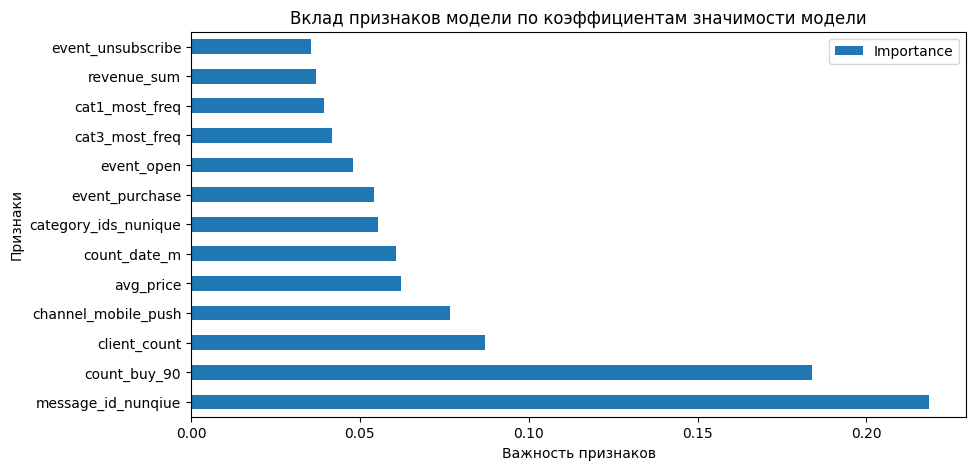

In [133]:
feature_imp = (pd.DataFrame({'Feature': X.columns, 
                             'Importance': np
                             .abs(coefficients)})
               .sort_values(by='Importance', ascending=False))
print(feature_imp)
feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10,5))
plt.title('Вклад признаков модели по коэффициентам значимости модели')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()

Наибольший вклад имеют признаки `message_id_nunqiue` и `count_buy_90` с сильным отрывом от остальных.

In [134]:
results = randomized_search_xgb.cv_results_

In [135]:
pd.DataFrame(randomized_search_xgb.cv_results_).sort_values('rank_test_score').head()

mean_fit_time         std_fit_time      mean_score_time  \
12  0.047515392303466797 0.003426129576952190 0.014106607437133789   
72  0.071887874603271479 0.007664911958258871 0.009375000000000000   
239 0.109375047683715823 0.009882193120737291 0.012500333786010741   
222 0.115624570846557612 0.012499797360209446 0.009390258789062500   
153 0.112500524520874029 0.011693303834108722 0.009374904632568359   

          std_score_time      param_subsample  param_scale_pos_weight  \
12  0.004330423540944334 1.000000000000000000                       2   
72  0.007654655456593822 1.000000000000000000                       1   
239 0.006250166939160995 1.000000000000000000                       3   
222 0.007667163397412326 0.900000000000000022                       1   
153 0.007654577594362773 1.000000000000000000                       3   

         param_reg_lambda       param_reg_alpha  param_n_estimators  \
12  10.000000000000000000  0.100000000000000006                 100   
72   0.100000000000000006 10.000000000000000000                 200   
239  1.000000000000000000  1.000000000000000000                 200   
222  0.100000000000000006 10.000000000000000000                 200   
153  0.100000000000000006  0.100000000000000006                 200   

     param_min_child_weight  ...  param_colsample_bytree  \
12                        2  ...    0.800000000000000044   
72                        3  ...    0.900000000000000022   
239                       3  ...    0.800000000000000044   
222                       3  ...    1.000000000000000000   
153                       3  ...    0.800000000000000044   

                                                params    split0_test_score  \
12   {'subsample': 1.0, 'scale_pos_weight': 2, 'reg... 0.723569990484989711   
72   {'subsample': 1.0, 'scale_pos_weight': 1, 'reg... 0.731113049353944611   
239  {'subsample': 1.0, 'scale_pos_weight': 3, 'reg... 0.729031353567669127   
222  {'subsample': 0.9, 'scale_pos_weight': 1, 'reg... 0.725897605618912367   
153  {'subsample': 1.0, 'scale_pos_weight': 3, 'reg... 0.728464819743416481   

       split1_test_score    split2_test_score    split3_test_score  \
12  0.695399584465251852 0.684110852167997496 0.736668643214694496   
72  0.700498388883526113 0.673132966522792309 0.726958851028034814   
239 0.692617478200513892 0.675383013638181318 0.725623531953426992   
222 0.705647181580411065 0.672908881135917625 0.728910117627590726   
153 0.693032323455189614 0.674201106866895605 0.726232584543394344   

       split4_test_score      mean_test_score       std_test_score  \
12  0.720307012666907553 0.712011216599968244 0.019312124849357366   
72  0.723850758439199771 0.711110802845499435 0.021764633454136761   
239 0.732494393943605826 0.711029954260679498 0.022836237466780769   
222 0.721533627072155959 0.710979482606997504 0.020655518209135817   
153 0.731977223658484610 0.710781611653476086 0.023038458897464704   

     rank_test_score  
12                 1  
72                 2  
239                3  
222                4  
153                5  

[5 rows x 24 columns]

In [136]:
best_model = randomized_search_xgb.best_estimator_

In [137]:
y_proba = best_model.predict_proba(X_test)[:, 1]

In [138]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC_AUC_SCORE: {roc_auc}')

ROC_AUC_SCORE: 0.7402290358484713


In [139]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

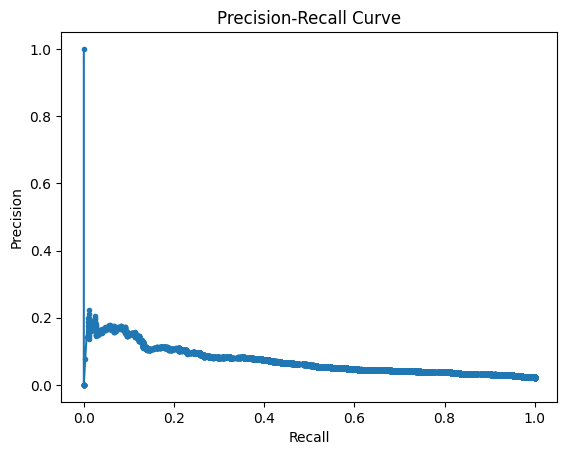

In [140]:
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

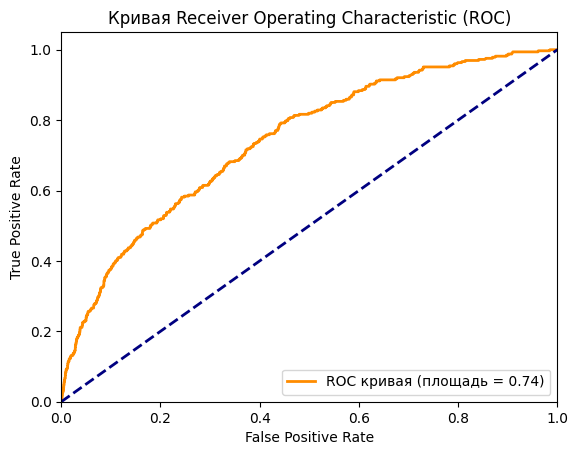

In [141]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, 
         tpr, 
         color='darkorange', 
         lw=2, 
         label='ROC кривая (площадь = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Кривая Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Построим график общей значимости признаков используя SHAP.

In [142]:
explainer = (shap
             .TreeExplainer(randomized_search_xgb
                              .best_estimator_,
                              X_test, 
                              feature_names=X.columns))

In [143]:
shap_values = explainer(X_test, check_additivity=False)

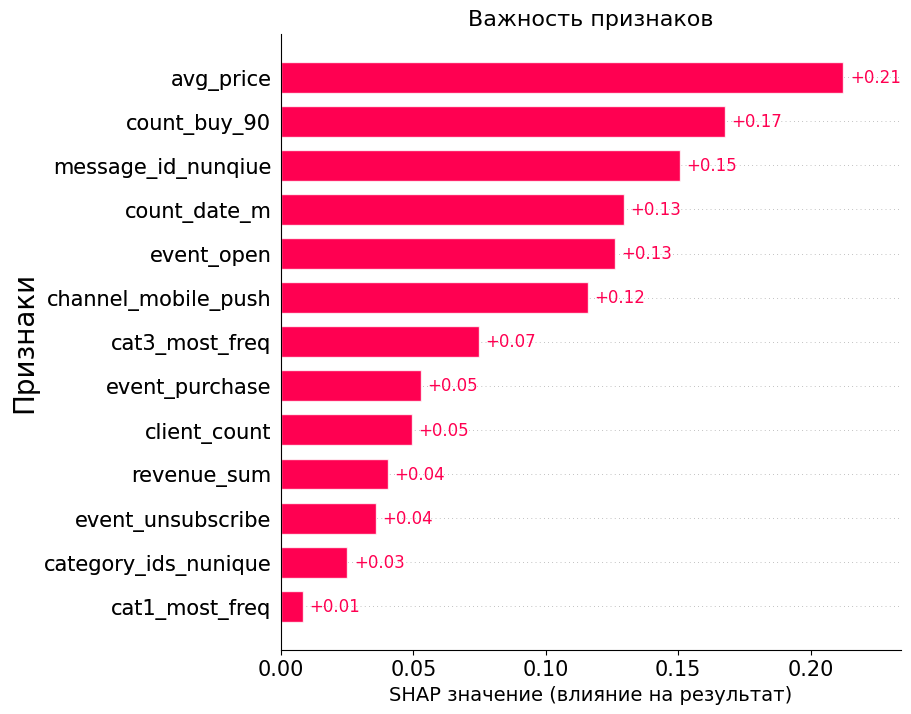

In [144]:
plt.title('График общей значимости признаков')
shap.plots.bar(shap_values, max_display = 29, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP значение (влияние на результат)", fontsize=14)
ax.set_title('Важность признаков', fontsize=16)

# Get colorbar
cb_ax = fig.axes[0] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Признаки", fontsize=20)

plt.show()

`count_buy_90` и `message_id_nunqiue` также имеют наибольший вклад по значимости, однако на первом месте теперь признак `avg_price`. <br/>

<a id='report_learn'></a>
# Предварительный вывод

Для обучения мы использовали *XGBClassifier* и *GradientBoostingClassifier*. Эти модели хорошо работает с количественными признаками и не требуют применения масштабирования.<br/>
Наиболее высокая метрика у *XGBClassifier* поэтому использовали ее в дальнейшем. <br/>
ROC_AUC_SCORE на кросс-валидации: 0.7120112165999682 <br/>
ROC_AUC_SCORE на тестовой выборке: 0.7402290358484713 <br/>
Наибольший вклад имеют признаки `message_id_nunqiue` и `count_buy_90` с сильным отрывом от остальных. <br/>
Анализ важности признаков с помощью SHAP добавил к этим двум еще признак `avg_price`. <br/>

<a id='predict'></a>
# Предсказание

In [145]:
y_pred = best_model.predict(X_test)

In [146]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14628
           1       0.00      0.00      0.00       327

    accuracy                           0.98     14955
   macro avg       0.49      0.50      0.49     14955
weighted avg       0.96      0.98      0.97     14955



In [147]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

   Actual  Predicted
0   14628      14953
1     327          2


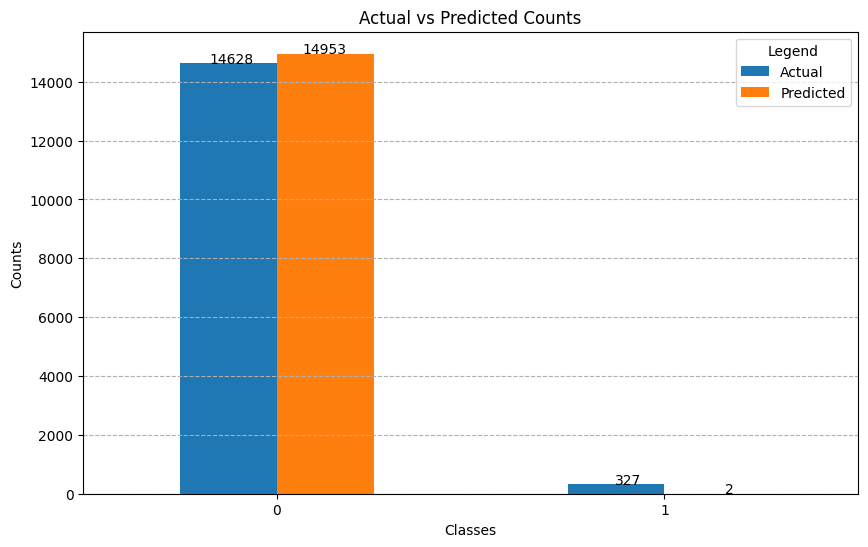

In [148]:
# Подсчет количества для каждого класса
count_actual = results['Actual'].value_counts()
count_predicted = results['Predicted'].value_counts()

counts = pd.DataFrame({
    'Actual': count_actual,
    'Predicted': count_predicted
})

print(counts)

counts.plot(kind='bar', figsize=(10, 6))
plt.title('Actual vs Predicted Counts')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=0)  
plt.legend(title='Legend', loc='upper right')
plt.grid(axis='y', linestyle='--')

for index, value in enumerate(counts['Actual']):
    plt.text(index - 0.06, value + 0.05, int(value), ha='right')

for index, value in enumerate(counts['Predicted']):
    plt.text(index + 0.18, value + 0.5, int(value), ha='right')

plt.show()

<a id='total_review'></a>
# Общий вывод

В рамках данного проекта необходимо было ***Предсказать вероятность покупки в течение 90 дней***. <br/>
Для этого заказчиком были предоставлены три датафрейма: *apparel-purchases*, *apparel-messages* и *apparel-target_binary*. <br/>

На этапе ***подготовки данных*** все три датафрейма и рассмотрена общая информация по ним. </br>
Увидели что датафрейм `apparel-messages` содержит 12739798 строк и 7 признаков. Признаки содержат числовые, даты и строковые типы данных. Кроме того выявлено 48610 явных дубликатов. При этом признак `event` содержит 11 уникальных значений, а признак `channel` - 2. Признак `created_at` дублирует признак `date` кроче добавления времени, поэтому никакой ценности не несет. </br>
Датафрейм `apparel-purchases` содержит 202208 строк и 6 признаков. Признаки содержат числовые, даты и строковые типы данных. Кроме того выявлено 73020 явных дубликатов. </br>
Датафрейм `apparel-target_binary` содержит 49849 строк и 2 признака, один из которых бинарный.</br>
Также определилили что признак `client_id` присутствует в каждом датасете, поэтому он будет использоваться в качестве ключевого.</br>

Следующим этапом была ***предобработка данных*** на котором мы провели предобработку данных для дальнейшего анализа. Удалили все явные дубликаты, а также признак `created_at`.<br/>
После предобработки данных, `apparel-messages` содержит 12691188 строк и 6 признаков, а `apparel-purchases` содержит 129188 и 6 признаков.<br/>

Для проведения ***исследовательского анализа*** мы разбили признак `category_ids_` на 5 отдельных категорий и назвали их: `cat1`, `cat2`, `cat3`, `cat4`, `cat5`.<br/>
Затем добавили два новых признака: <br/>
`count_buy_90` - который показывает сколько покупок совершил клиент за последние 90 дней <br/>
`revenue` - который показывает выручку по каждой покупке <br/>
`month` - который показывает первый день месяца покупки <br/>
Затем мы создали новый датафрейм для анализа покупок и построили несколько графиков.
График по выручке показал что июнь это топ-1 и топ-3 месяц по выручке. Возможно это связано что основная часть категории товаров относится к летнему периоду.<br/>
Средняя выручка распределена более стабильно по месяцам для активного пользователя, при этом в последнее время видится небольшое увеличение среднего чека.  <br/>
Графики для активных и новых пользователей, а также их выручки соблюдает единый тренд в котором видится увеличение выручки с увеличением числа клиентов.  <br/>
Средняя выручка на нового и активного пользователя также сохраняет единый тренд, но средняя выручка нового пользователя при этом чуть больше.  <br/>
Диаграмма рессяния показала что с увеличением новых и активных пользователей выручка растет.<br/> 
С увеличением цены растет и выручка, но увеличение количества товаров не влияет на выручку, возможно покупалось много товаров по низкой цене. <br/>
Целевой признак `target` сильно несбалансирован (961 значение против 48888). <br/>
График долей показал что на четвертую категорию приходится почти 58% от всех покупок.  <br/>
Выручка, как и цена, сконцентрированы около 1000 руб., но стоит отметить единичные покупки стоимостью более 40 тыс. руб.<br/>
Количество покупок по 4 категории превышает остальные больше чем в два раза, эта категория и принесла наибольшее количество выручки. <br/>
При этом, несмотря на меньшее количество покупок для категории 2, выручка по ней больше, это говорит о том, что товары этой категории стоят дороже. <br/>
Средняя выручка по 4 категории при этом не самая высокая, наибольшая средняя выручка у категории 2 и у категории 5963, кроме того цена для 4 категории имеет наибольший разброс. <br/>
Наибольшая средняя цена у позиции товара *[4, 29, 313, 1574]*. <br/>
Стоит отметить что не всегда наиболее популярные категории приносят наибольшую выручку, в первую очередь за счет увеличенной средней цены других категорий. <br/>
Наибольшее количество отправленных сообщений имеют статус *send* (72%), и наиболее предпочтительный вариант отправки сообщений - *mobile_push*. <br/>
Три наиболее популярных статусов у сообщений - *send*, *open*, *click*. Стоит отмметить что *purchase* не входит в топ3, что говорит о низкой конверсии этих сообщений. <br/>
Несмотря на то, что основной канал отправки сообщений это *mobile_push*, статус *purchase* более чем в два раза лучше у типа связи *email*. <br/>
График показывает что некоторые рекламные компании имеют агрессивный характер и отправляют огромное количество сообщений. Это не всегда эффективно, к примеру, рекламная компания 4679 имеет гораздо лучшую конверсию покупок к количеству отправленных сообщений. <br/>

Перед тем как приступить к обучению модели, мы провели ***работу с признаками***. На данном этапе объединили все датафреймы в один по ключу `client_id`, дополнительно, при группировке, создав следующие признаки: <br/>
- `client_count` - количество заказов у пользователя<br/>
- `quantity_sum` - количество купленных товаров у пользователя<br/>
- `revenue_sum` - выручка<br/>
- `message_id_nunqiue` - количество уникальных сообщений отправленных пользователю<br/>
- `first_date` - минимальная дата покупки<br/>
- `last_date` - последняя дата покупки<br/>
- `category_ids_nunique` - количество купленных уникальных категорий<br/>
- `cat1_most_freq` - наиболее часто встречающаяся категория для `cat1` <br/>
- `cat2_most_freq` - наиболее часто встречающаяся категория для `cat2` <br/>
- `cat3_most_freq` - наиболее часто встречающаяся категория для `cat3` <br/>
- `cat4_most_freq` - наиболее часто встречающаяся категория для `cat4` <br/>
- `cat5_most_freq` - наиболее часто встречающаяся категория для `cat5` <br/>
- `count_buy_90` - количество покупок у клиента за последние 90 дней<br/>
- `bulk_campaign_id_nunique` - количество уникальных рекламных компаний<br/>
- `message_id_nunqiue_m` - количество уникальных сообщений отправленных пользователю<br/>
- `first_date_m` - минимальная дата отправки сообщения клиенту<br/>
- `last_date_m` - максимальная дата отправки сообщения клиенту<br/>
- `count_date_m` - количество дней когда рассылались сообщения<br/>
- `bulk_campaign_id` - количество уникальных рекламных компаний<br/>
- `bulk_campaign_id` - количество уникальных рекламных компаний<br/>
Корреляционная матрица показала нам большое количество коррелирующих признаков, что также подтвердил показатель *variance inflation factor*.  <br/>
После удаления сильно коррелирующих признаков, в нашем датафрейме осталось 49849 строк и 14 признаков.<br/>

Для ***обучения*** мы использовали *XGBClassifier* и *GradientBoostingClassifier*. Эти модели хорошо работает с количественными признаками и не требуют применения масштабирования.<br/>
Наиболее высокая метрика у *XGBClassifier* поэтому использовали ее в дальнейшем. <br/>
ROC_AUC_SCORE на кросс-валидации: 0.7120112165999682 <br/>
ROC_AUC_SCORE на тестовой выборке: 0.7402290358484713 <br/>
Наибольший вклад имеют признаки `message_id_nunqiue` и `count_buy_90` с сильным отрывом от остальных. <br/>
Анализ важности признаков с помощью SHAP добавил к этим двум еще признак `avg_price`. <br/>

***Сравнение прогнозов*** показало снижение количество покупательской активности в ближайшие 90 дней. ***В качестве рекомендаций***:
1. Стоит обратить внимание на привлечение новых и активных пользователей, так как в некоторые месяцы отмечается сильное снижение покупательской активности;
2. Также стоит провести какие-то рекламные акции для продвижения других категорий, особенно тех, у которых средняя цена выше (сейчас основная категория *4* занимает почти 60% продаж)
3. Кроме того следует сделать упор на канал `email`, так как через него больше конверсия в покупки чем через `mobile_push`.
4. Стоит посмотреть на удачные рекламные компании, у которых конверсия покупок выше чем у других, и сделать основной упор на них при рассылке сообщений.